# Progetto Wine Type
## Machine Learning - Febbraio 2024
##Università degli Studi Milano Bicocca - CdLM Informatica - AA 2023/2024

**Cavaleri Matteo** - 875050  
**Gargiulo Elio** - 869184  
**Piacente Cristian** - 866020


# Librerie utilizzate

In [ ]:
# Import librerie

try:
  import keras_tuner as kt
except ModuleNotFoundError as ex:
  if 'No module named \'keras_tuner\'' in str(ex):
    print("Installing keras_tuner")
    %pip install keras-tuner -q
    # non è preinstallato su colab

import keras_tuner as kt

import numpy as np
import sklearn as sn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import scipy.stats as st

from matplotlib.patches import Patch

from time import time

from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, make_scorer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, ShuffleSplit, LearningCurveDisplay

import tensorflow as tf
from tensorflow import keras

# Import del dataset

Viene importato il dataset, descritto in una successiva sezione, da un file csv e memorizzato in un DataFrame della libreria Pandas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Creazione dataframe
df = pd.read_csv("drive/MyDrive/Colab Notebooks/winequalityN.csv") # https://www.kaggle.com/datasets/rajyellow46/wine-quality

# Visualizzazione prime righe
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

## Cast colonne e label encoding per il target type

A questo punto è necessario capire se servono cast per i tipi delle features e del target, per evitare che le analisi portino a risultati errati a causa di una interpretazione diversa dei dati a disposizione.

In [ ]:
# Tipi di dato per capire se servono cast
df.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Type (white/red), poiché può assumere solo due valori, ha bisogno di essere convertito in bool: si effettua label encoding associando alla classe red False e alla classe white True.

Quality, dalla descrizione del dataset presente in una successiva sezione, in generale può assumere solo valori da 0 a 10: questo significa che è una variabile categorica, è necessario il cast a category.

In [ ]:
# Cast ai tipi corretti

df['type'] = LabelEncoder().fit_transform(df['type']) # label encoding (red = False, white = True)
df['type'] = df['type'].astype(bool) # cast a bool

df['quality'] = df['quality'].astype('category') # quality va da 0 a 10

# Nuovi tipi
df.dtypes

type                        bool
fixed acidity            float64
volatile acidity         float64
citric acid              float64
residual sugar           float64
chlorides                float64
free sulfur dioxide      float64
total sulfur dioxide     float64
density                  float64
pH                       float64
sulphates                float64
alcohol                  float64
quality                 category
dtype: object

## Pulizia iniziale dataset

Ora è necessario ripulire il dataset da eventuali righe con valori mancanti (NaN) e da eventuali righe duplicate.

In [ ]:
# Dimensione del dataframe prima della pulizia (numero istanze, numero features + target)
df.shape

(6497, 13)

In [ ]:
# Valori mancanti
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [ ]:
# Eliminazione valori mancanti
df.dropna(inplace=True)

In [ ]:
# Controllo righe duplicate
df.duplicated().sum()

1168

In [ ]:
# Eliminazione righe duplicate
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

In [ ]:
# Nuova dimensione dopo la pulizia
df.shape

(5295, 13)

In [ ]:
# Visualizzazione nuove prime righe
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  True            7.0              0.27         0.36            20.7   
1  True            6.3              0.30         0.34             1.6   
2  True            8.1              0.28         0.40             6.9   
3  True            7.2              0.23         0.32             8.5   
6  True            6.2              0.32         0.16             7.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
6      0.045                 30.0                 136.0   0.9949  3.18   

   sulphates  alcohol quality  
0       0.45      8.8       6  
1       0.49      9.5       6  
2       0.44     10.1       6  
3       0.40      9.9       6  
6       0.47      9.6       6

In [ ]:
# Riepilogo colonne e tipi
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5295 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   type                  5295 non-null   bool    
 1   fixed acidity         5295 non-null   float64 
 2   volatile acidity      5295 non-null   float64 
 3   citric acid           5295 non-null   float64 
 4   residual sugar        5295 non-null   float64 
 5   chlorides             5295 non-null   float64 
 6   free sulfur dioxide   5295 non-null   float64 
 7   total sulfur dioxide  5295 non-null   float64 
 8   density               5295 non-null   float64 
 9   pH                    5295 non-null   float64 
 10  sulphates             5295 non-null   float64 
 11  alcohol               5295 non-null   float64 
 12  quality               5295 non-null   category
dtypes: bool(1), category(1), float64(11)
memory usage: 507.1 KB


# Descrizione dataset e analisi esplorativa

Il dataset riguarda la classificazione binaria (red/white) di vini date le seguenti features:
- fixed acidity g(tartaric acid)/dm
- volatile acidity g(acetic acid)/dm
- citric acid g/dm
- residual sugar g/dm
- chlorides g(sodium chloride)/dm
- free sulfur dioxide mg/dm
- total sulfur dioxide mg/dm
- density g/dm
- pH
- sulphates g(potassium sulphate)/dm
- alcohol %vol
- quality.

La qualità di un vino si esprime con un valore da 0 a 10, mentre le altre features, che sono proprietà chimiche, sono esprimibili attraverso valori continui.

## Analisi delle covariate e del target

### Statistiche

Statistiche senza separare le due classi di vini

In [ ]:
# Describe restituisce anche i quartili quindi poi non serve fare boxplot
df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    5295.000000       5295.000000  5295.000000     5295.000000   
mean        7.218008          0.344021     0.318782        5.051029   
std         1.320690          0.168237     0.147112        4.500641   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.240000        1.800000   
50%         7.000000          0.300000     0.310000        2.700000   
75%         7.700000          0.410000     0.400000        7.500000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  5295.000000          5295.000000           5295.000000  5295.000000   
mean      0.056690            30.046837            114.118225     0.994536   
std       0.036901            17.827151             56.787187     0.002969   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            16.000000             74.000000     0.992200   
50%       0.047000            28.000000            116.000000     0.994670   
75%       0.066000            41.000000            154.000000     0.996780   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  5295.000000  5295.000000  5295.000000  
mean      3.224385     0.533199    10.550154  
std       0.160155     0.149851     1.186533  
min       2.720000     0.220000     8.000000  
25%       3.110000     0.430000     9.500000  
50%       3.210000     0.510000    10.400000  
75%       3.330000     0.600000    11.400000  
max       4.010000     2.000000    14.900000

In [ ]:
# Skewness (asimmetria) features numeriche

# Mi dice se una delle due code è più lunga rispetto a quella della distribuzione normale:
# i valori negativi mi fanno osservare che la coda sinistra è più lunga,
# mentre i valori positivi che la coda destra è più lunga.

# Confermeremo poi coi grafici

df.iloc[:, 1:12].skew()

fixed acidity           1.648811
volatile acidity        1.510289
citric acid             0.486635
residual sugar          1.707607
chlorides               5.343378
free sulfur dioxide     1.363486
total sulfur dioxide    0.063036
density                 0.666396
pH                      0.396474
sulphates               1.814488
alcohol                 0.545721
dtype: float64

In [ ]:
# Curtosi features numeriche

# Se minore di 0 si ha una distribuzione platicurtica (maggiore appiattimento rispetto alla normale),
# mentre se maggiore di 0 si ha una distribuzione leptocurtica (maggiore allungamento).

# Confermeremo poi coi grafici

df.iloc[:, 1:12].kurtosis()

fixed acidity            4.581830
volatile acidity         2.885402
citric acid              2.597669
residual sugar           7.049446
chlorides               48.283734
free sulfur dioxide      9.511998
total sulfur dioxide    -0.299378
density                  8.709492
pH                       0.446455
sulphates                8.634370
alcohol                 -0.539457
dtype: float64

Statistiche per i vini rossi

In [ ]:
# Sotto-dataframe con solo vini rossi
red_df = df[df['type'] == False]

red_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1353.000000       1353.000000  1353.000000     1353.000000   
mean        8.318477          0.529294     0.273016        2.522986   
std         1.736520          0.183323     0.195585        1.354667   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.100000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.430000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1353.000000          1353.000000           1353.000000  1353.000000   
mean      0.088163            15.854398             46.822986     0.996715   
std       0.049463            10.418830             33.432546     0.001870   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996700   
75%       0.091000            21.000000             63.000000     0.997830   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol  
count  1353.000000  1353.000000  1353.000000  
mean      3.309165     0.658374    10.428394  
std       0.154938     0.170917     1.081636  
min       2.740000     0.330000     8.400000  
25%       3.210000     0.550000     9.500000  
50%       3.310000     0.620000    10.200000  
75%       3.400000     0.730000    11.100000  
max       4.010000     2.000000    14.900000

Statistiche per i vini bianchi

In [ ]:
# Sotto-dataframe con solo vini bianchi
white_df = df[df['type'] == True]

white_df.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    3942.000000       3942.000000  3942.000000     3942.000000   
mean        6.840297          0.280430     0.334490        5.918721   
std         0.866067          0.103256     0.122404        4.861389   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.600000   
50%         6.800000          0.260000     0.320000        4.700000   
75%         7.300000          0.328750     0.390000        8.875000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  3942.000000          3942.000000           3942.000000  3942.000000   
mean      0.045887            34.918062            137.215753     0.993788   
std       0.023088            17.227540             43.128509     0.002907   
min       0.009000             2.000000              9.000000     0.987110   
25%       0.035000            23.000000            106.000000     0.991600   
50%       0.042000            33.000000            133.000000     0.993500   
75%       0.050000            45.000000            166.000000     0.995710   
max       0.346000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  3942.000000  3942.000000  3942.000000  
mean      3.195287     0.490236    10.591945  
std       0.151345     0.113653     1.217787  
min       2.720000     0.220000     8.000000  
25%       3.090000     0.410000     9.500000  
50%       3.180000     0.480000    10.400000  
75%       3.290000     0.550000    11.400000  
max       3.820000     1.080000    14.200000

### Grafici

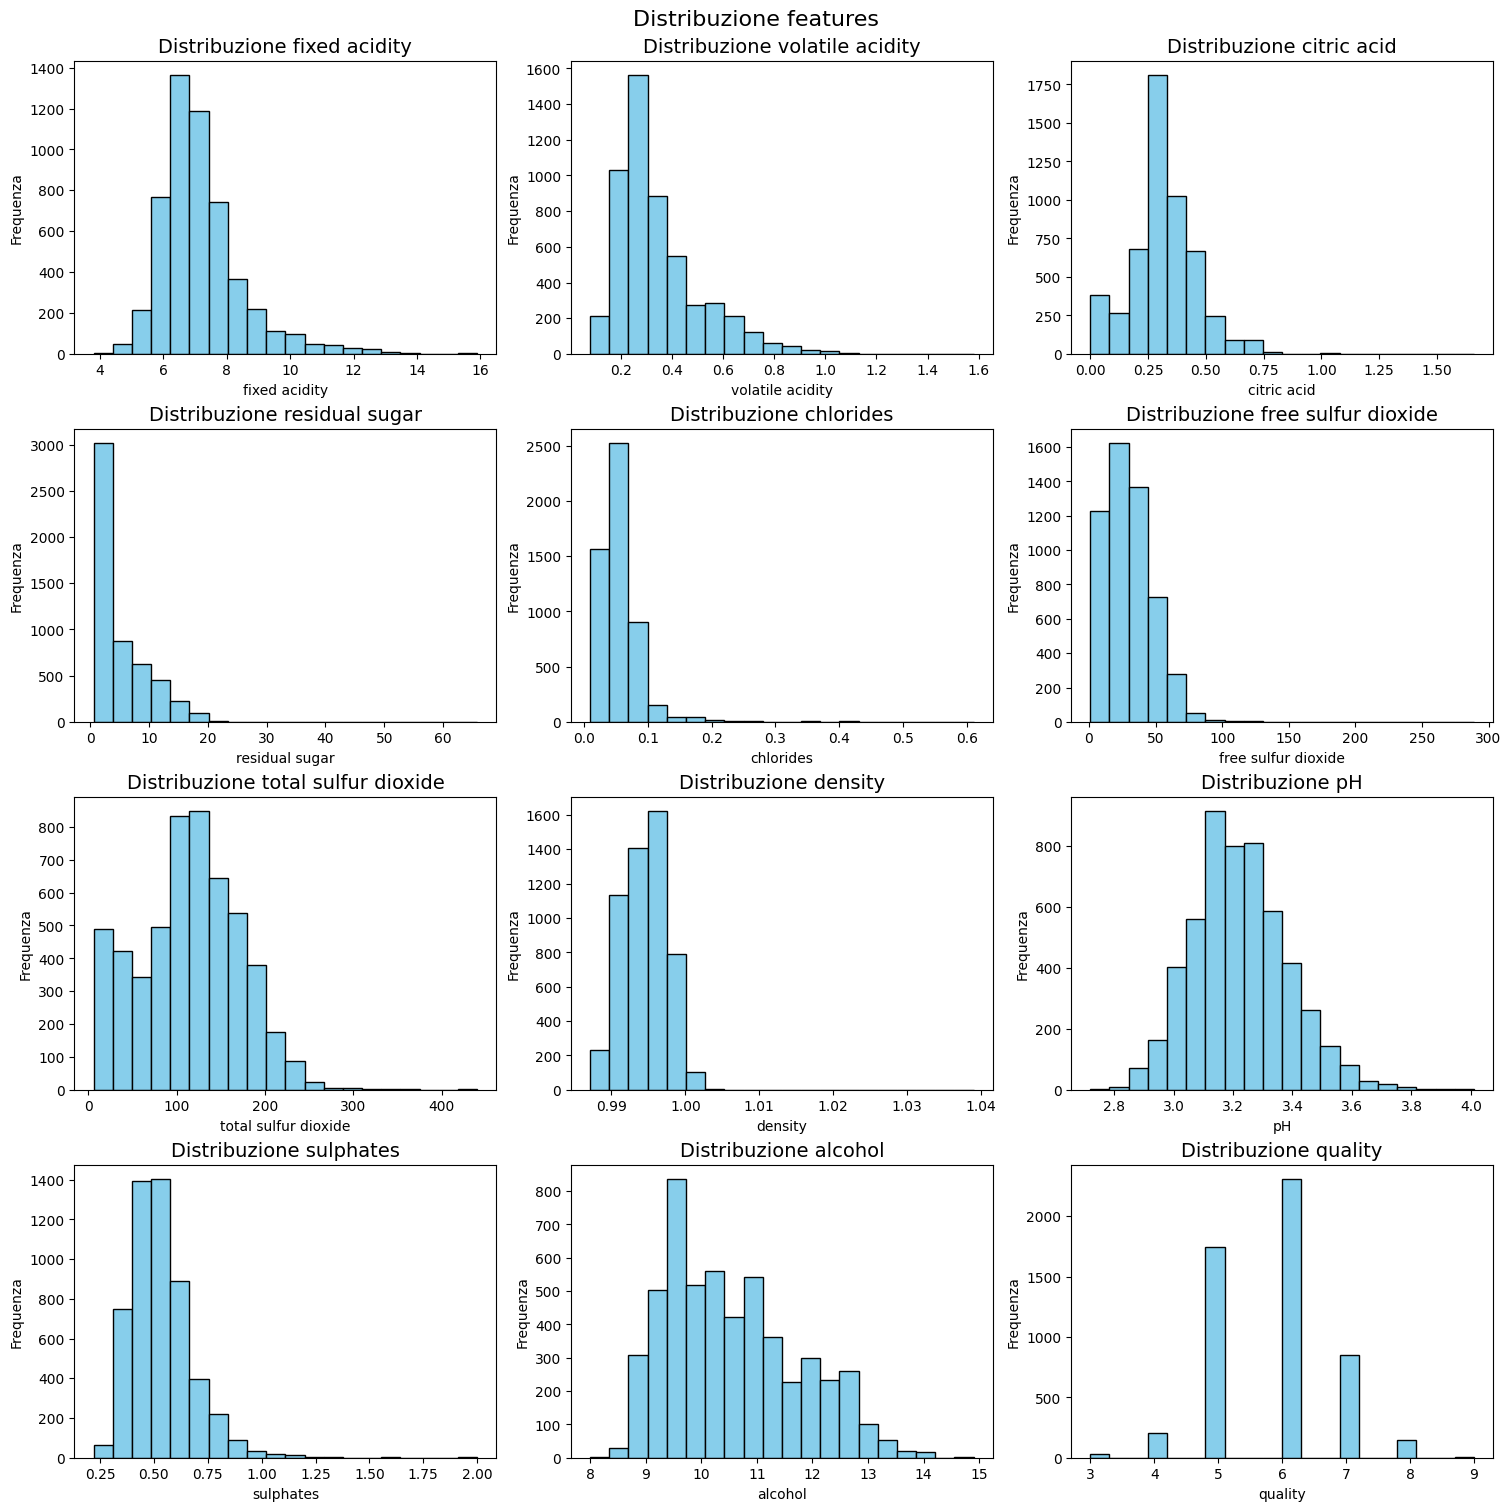

In [ ]:
# Distribuzione features
# Utile anche per mostrare che non ci sono colonne che assumono un solo valore

(row, col) = (0, 0)

fig, axs = plt.subplots(4, 3, figsize=(15, 15), constrained_layout = True)

fig.suptitle('Distribuzione features', fontsize=16)

for i in range(1, 13): # anche se quality è già stata considerata
    ax = axs[row, col]

    col = (col + 1) % 3
    if col == 0:
        row += 1

    column = df[df.columns[i]]

    ax.hist(column, bins=20, color='skyblue', edgecolor='black')

    ax.set_title('Distribuzione ' + df.columns[i], fontsize=14)

    ax.set_xlabel(df.columns[i])
    ax.set_ylabel('Frequenza')

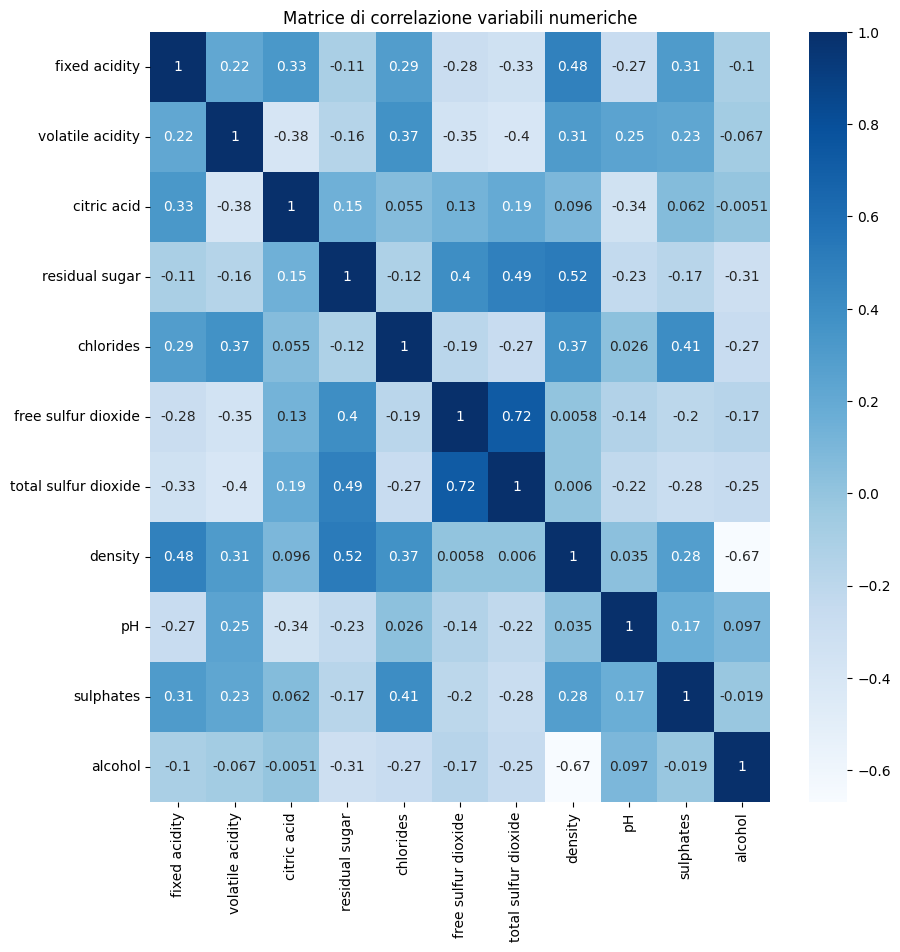

In [ ]:
# Matrice di correlazione per le variabili numeriche

corr_matrix = df.iloc[:, 1:12].corr() # escludo type e quality

plt.figure(figsize=(10,10))
plt.title("Matrice di correlazione variabili numeriche")
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues');

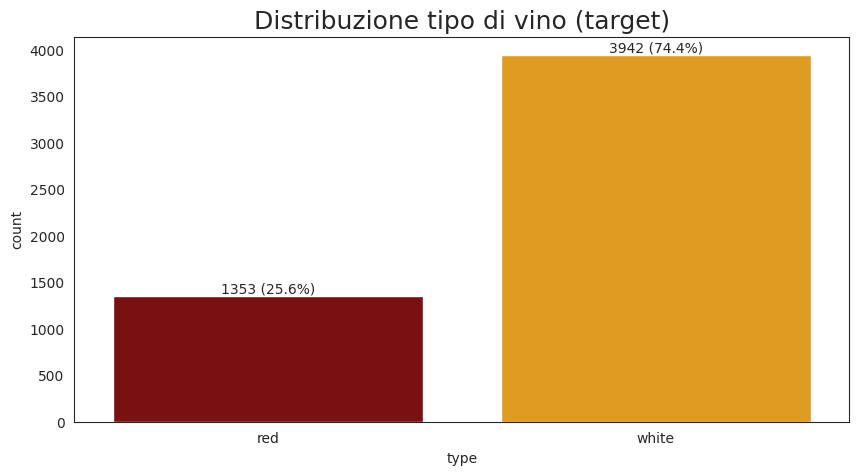

In [ ]:
# Distribuzione valori target

plt.figure(figsize=(10, 5))
plt.title("Distribuzione tipo di vino (target)", size=18)
ax = sns.countplot(x=df['type'], hue=df['type'], palette=['darkred', 'orange'])

ax.set_xticks([0, 1])
ax.set_xticklabels(['red', 'white'])

plt.legend().set_visible(False)

total = len(df["type"])
for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        ax.text(p.get_x() + p.get_width()/2., height + 30, str(height) + ' (' + str(percentage) + ')', ha="center")

plt.show()

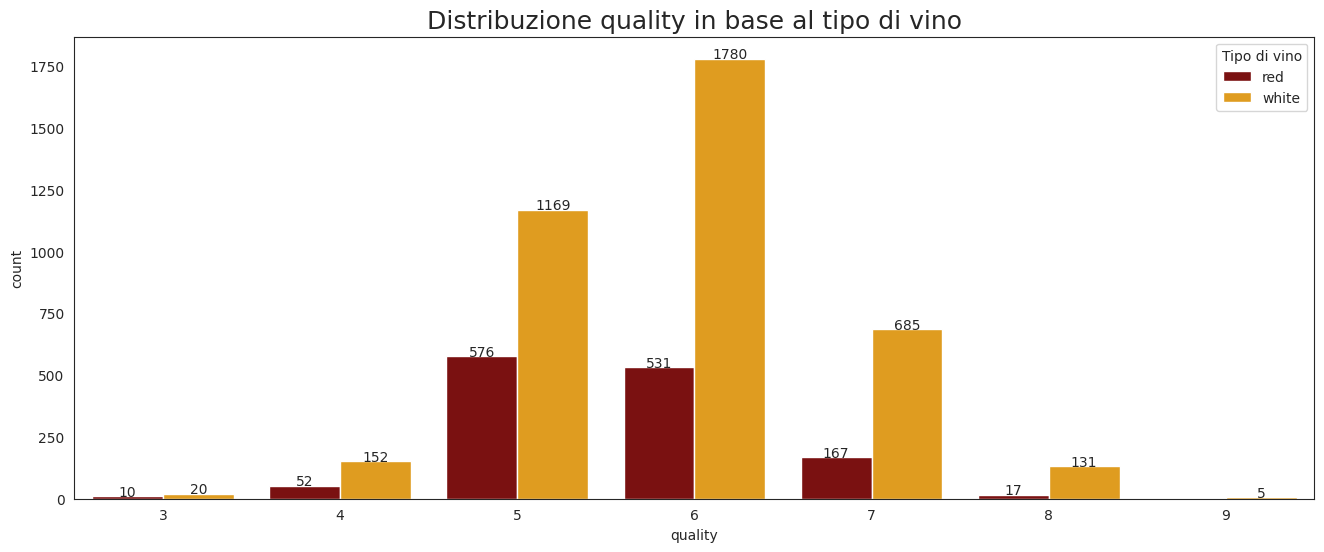

In [ ]:
# Istogramma distribuzione quality a seconda del tipo

plt.figure(figsize=(16, 6))
plt.title("Distribuzione quality in base al tipo di vino", size=18)
ax = sns.countplot(x=df['quality'], hue=df['type'], data=df, palette=['darkred', 'orange'])
plt.legend(title='Tipo di vino', labels=['red', 'white'])

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 1, height, ha="center")

plt.show()

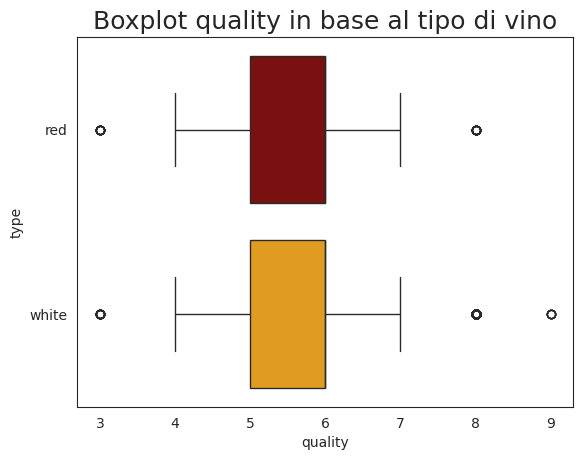

In [ ]:
# Boxplot che ci farà dire che possiamo droppare la colonna quality
# Reminder: i baffi sono Q1 - 1.5 * IQR e Q3 + 1.5 * IQR

plt.title("Boxplot quality in base al tipo di vino", size=18)
ax = sns.boxplot(x=df["quality"], y=df["type"], hue=df['type'], data=df, orient='h', palette=['darkred', 'orange'])
ax.set_yticks([0, 1])
ax.set_yticklabels(['red', 'white'])
plt.legend().set_visible(False)
plt.show()

### Drop della colonna quality



In [ ]:
# Dal boxplot abbiamo visto che la quality non aggiunge informazione sul tipo di vino
df.drop(columns='quality', inplace=True)
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  True            7.0              0.27         0.36            20.7   
1  True            6.3              0.30         0.34             1.6   
2  True            8.1              0.28         0.40             6.9   
3  True            7.2              0.23         0.32             8.5   
6  True            6.2              0.32         0.16             7.0   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
6      0.045                 30.0                 136.0   0.9949  3.18   

   sulphates  alcohol  
0       0.45      8.8  
1       0.49      9.5  
2       0.44     10.1  
3       0.40      9.9  
6       0.47      9.6

In [ ]:
# Nuova dimensione dopo il drop della colonna quality
df.shape

(5295, 12)

## Analisi esplorativa con Principal Component Analysis


Poiché il dataset, nello stato attuale, contiene solo features continue è sensato tentare di applicare l'analisi esplorativa con Principal Component Analysis.

Le features continue sono quindi tutte le colonne del dataframe, escluso il target type.

Innanzitutto si effettua uno scaling per poter confrontare le variabili senza essere affetti da scale di valori diverse, poi la fit di PCA.

In [ ]:
# Prendo solo le features continue, escludo il target
indexes = list(range(1, 12))
features = [df.columns[i] for i in indexes]
print('Features continue: ', features)

# Standardizzazione delle features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# PCA
pca = PCA().fit(scaled_data)


Features continue:  ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


I primi due grafici che vengono analizzati riguardano il rapporto tra la varianza spiegata e il numero di componenti della PCA: questi permettono di capire di quante dimensioni (componenti) è possibile tenere il nuovo spazio, ottenuto tramite feature extraction, mantenendo un'alta percentuale di varianza cumulativa spiegata.

La parte inferiore del secondo grafico è chiamata scree plot, e visualizza tramite barre di un istogramma il rapporto appena trattato, mentre la parte superiore è una curva che mostra come cambia la varianza spiegata cumulativa in base al numero di componenti mantenute.

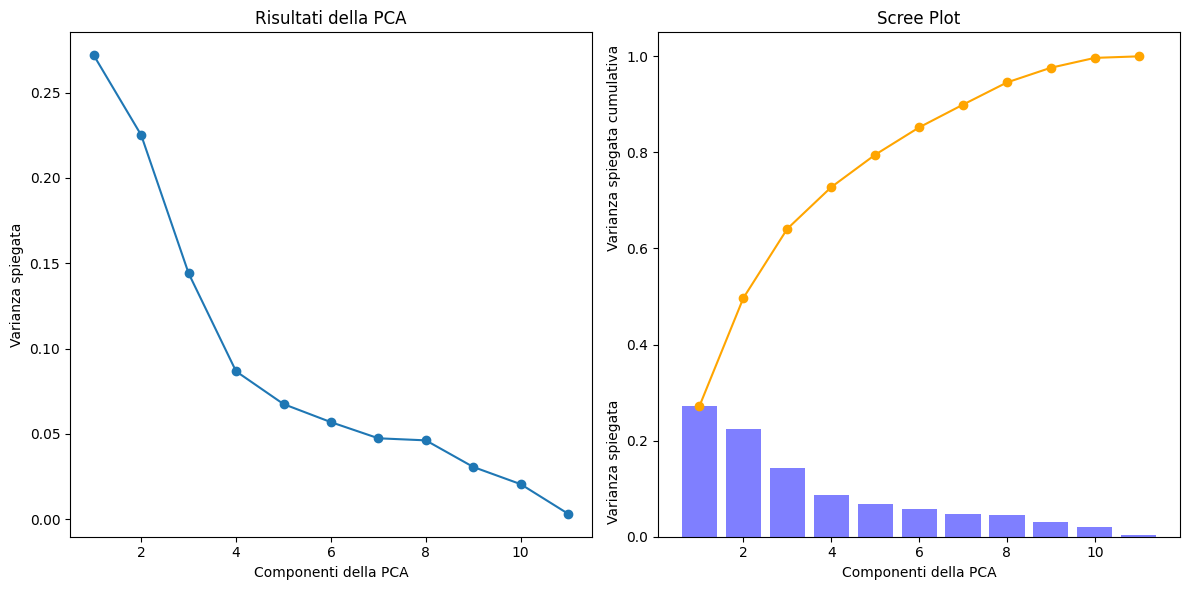

In [ ]:
# Grafico varianza spiegata per ogni componente
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")

# Calcola la varianza spiegata cumulativa e crea lo scree plot
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.subplot(1, 2, 2)
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color='blue', alpha=0.5, align='center')
plt.plot(range(1, pca.n_components_ + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata                                  Varianza spiegata cumulativa')
plt.title("Scree Plot")

plt.tight_layout()
plt.show()

Dai grafici si può vedere che con 5 componenti si mantiene circa l'80% della varianza spiegata cumulativa, che sembra soddisfacente.

In [ ]:
# Dimensionality reduction con 5 componenti
pca = PCA(n_components=5).fit(scaled_data)
pca_data = pca.transform(scaled_data)

Come conferma di quanto appena visto, e come ulteriore metodo di visualizzazione dei dati per ogni componente, di seguito si produce una tabella in cui sulle righe si mettono le componenti, mentre sulle colonne autovalore, varianza spiegata e varianza spiegata cumulativa.

Può essere utile come alternativa per decidere quante componenti tenere, siccome un altro criterio di scelta consiste nel considerare solo componenti con autovalore maggiore di 1.

In [ ]:
# Creazione tabella autovalore, percentuale varianza e percentuale varianza cumulativa

eigen_values = pca.explained_variance_
variance_ratio = pca.explained_variance_ratio_ * 100
cumulative_ratio = variance_ratio.cumsum()

pca_results = pd.DataFrame({
    'Eigenvalue': eigen_values,
    'Variance Percent': variance_ratio,
    'Cumulative Variance Percent': cumulative_ratio
})
pca_results.index = ['Comp ' + str(i+1) for i in pca_results.index]

pca_results

Eigenvalue  Variance Percent  Cumulative Variance Percent
Comp 1    2.991077         27.186472                    27.186472
Comp 2    2.476404         22.508515                    49.694986
Comp 3    1.585096         14.407246                    64.102232
Comp 4    0.953458          8.666165                    72.768397
Comp 5    0.742378          6.747617                    79.516014

Nel grafico seguente, si verifica se vi è una correlazione lineare tra le prime due componenti di PCA: se la risposta dovesse essere affermativa, allora ci sarebbe ridondanza tra i dati e non sarebbe significativo considerare il risultato della PCA.

Vengono scelte le prime due componenti poiché sono quelle con più alta varianza spiegata (e quindi anche autovalori più grandi).

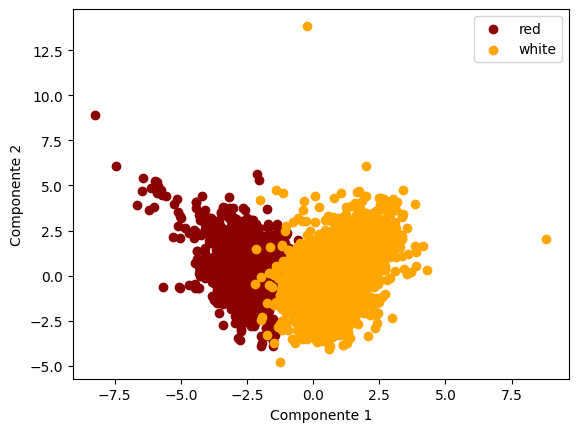

In [ ]:
# Generazione grafico in cui si mostra che c'è bassa correlazione

target_name = 'type'
unique_labels = np.unique(df[target_name])

fig, ax = plt.subplots()
for label in unique_labels:
    mask = (df[target_name] == label).values
    ax.scatter(pca_data[mask, 0], pca_data[mask, 1], color='darkred' if label == False else 'orange', label='red' if label == False else 'white')

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')

ax.legend()

plt.show()

A questo punto è possibile visualizzare la correlazione tra le variabili e le prime due componenti di PCA, che corrispondono rispettivamente all'asse x e y.

Ciascun vettore consente di ricavare diverse informazioni: due vettori correlati positivamente sono raggruppati insieme, mentre in caso di correlazione negativa si trovano in quadranti opposti, e infine è possibile quantificare la qualità di una singola feature in base alla distanza dall'origine.

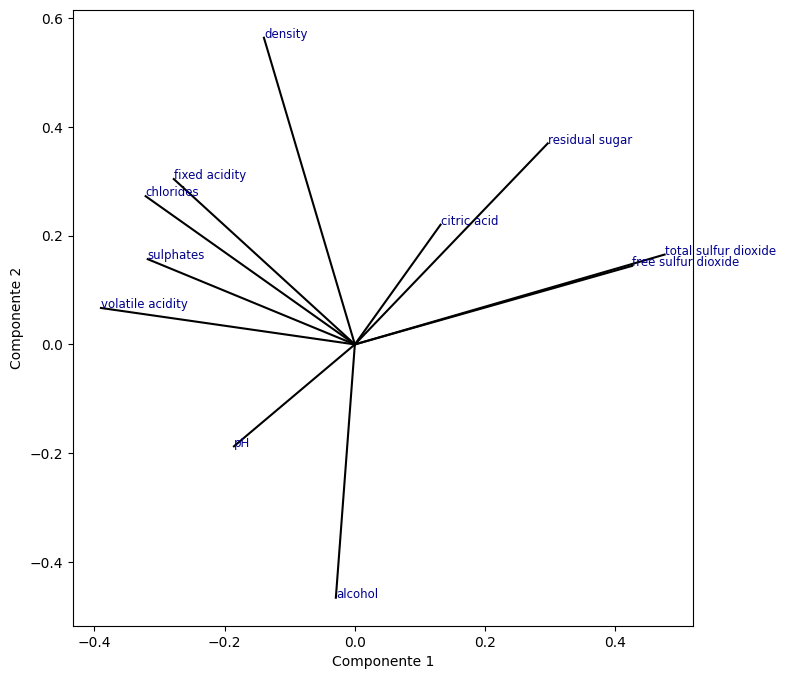

In [ ]:
# Grafico che mostra la correlazione delle variabili

pcs = pca.components_
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    ax.plot([0, x], [0, y], color='k')
    ax.text(x, y, df.columns[indexes[i]], fontsize=8.5, color='darkblue')

ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')

plt.show()

Infine, la seguente matrice di correlazione è un'ulteriore conferma del fatto che le 5 componenti di PCA risultanti hanno correlazione pressoché nulla.

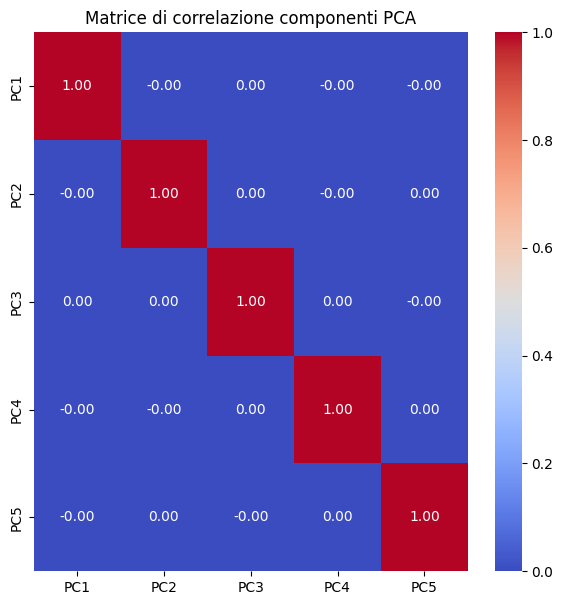

In [ ]:
# Conferma del fatto che le componenti della PCA non sono correlate

correlation_matrix = np.corrcoef(pca_data, rowvar=False)

plt.figure(figsize=(7,7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=["PC1", "PC2", "PC3", "PC4", "PC5"],
            yticklabels=["PC1", "PC2", "PC3", "PC4", "PC5"])
plt.title('Matrice di correlazione componenti PCA')
plt.show()

# Modelli ed esperimenti

## Divisione training, validation e test set (70-15-15%)

Per addestrare i modelli ed effettuare le predizioni dividiamo il dataset in training set e test set.

Un'ulteriore divisione riguarda training e validation set, quest'ultimo utilizzato in seguito per il tuning degli iperparametri.

In [ ]:
# Divido il dataset identificando le variabili e il target

X = pca_data # Features ridotte dalla PCA (5)
y = df['type'] # Target (bool)

# Numero componenti PCA
n_components = pca_data.shape[1]

# 70% training, 15% validation e 15% test
train_size = 0.7
validation_size = 0.15
test_size = 0.15

# Split iniziale: train+validation e test set
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Altro split, per avere training set e validation set
relative_validation_size = validation_size / (validation_size + train_size)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=relative_validation_size, random_state=42)

# Stampe delle dimensioni
print('Dimensione dati totali:', X.shape)
print('Dimensione dati training+validation:', X_train_validation.shape)
print()
print('Dimensione dati di training:', X_train.shape)
print('Dimensione dati di validation:', X_validation.shape)
print('Dimensione dati di test:', X_test.shape)

Dimensione dati totali: (5295, 5)
Dimensione dati training+validation: (4500, 5)

Dimensione dati di training: (3705, 5)
Dimensione dati di validation: (795, 5)
Dimensione dati di test: (795, 5)


## Funzione utilizzata da SVM e Albero Decisionale per Cross Validation

In [ ]:
# Preparativi per cross validation

# Misure utilizzate per ogni fold per la valutazione durante cross validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro')
}

print("Misure utilizzate durante cross validation:", ' '.join(scoring.keys()))

# La mia funzione che fa la cross validation e stampa tutto, di default fa la Stratified 10-fold cross validation
# Per altro passare un diverso parametro di cv
# Mentre model è un modello non fittato (o se volete uno già fittato ma poi dovrete rifittarlo correttamente se vi serve di nuovo)
def my_cross_validation(model, cv=StratifiedKFold(n_splits=10, shuffle=True)):
  scores = sn.model_selection.cross_validate(model, X, y, cv=cv, scoring=scoring)

  # Salvataggio in liste dei risultati di ogni fold
  accuracy_scores = scores['test_accuracy']
  precision_scores = scores['test_precision']
  recall_scores = scores['test_recall']
  f1_scores = scores['test_f1_score']

  # Per ogni metrica stampa della media, dei valori misurati per ogni fold e dell'intervallo di confidenza 95%

  current = accuracy_scores
  print("--- Accuracy di ogni fold, con media pari a", round(np.mean(current), 8), "---\n")
  print(current)
  print("\nIntervallo di confidenza 95%:", st.t.interval(confidence=0.95, df=len(current)-1, loc=np.mean(current), scale=st.sem(current)))
  print("\n")

  current = precision_scores
  print("--- Precision di ogni fold, con media pari a", round(np.mean(current), 8), "---\n")
  print(current)
  print("\nIntervallo di confidenza 95%:", st.t.interval(confidence=0.95, df=len(current)-1, loc=np.mean(current), scale=st.sem(current)))
  print("\n")

  current = recall_scores
  print("--- Recall di ogni fold, con media pari a", round(np.mean(current), 8), "---\n")
  print(current)
  print("\nIntervallo di confidenza 95%:", st.t.interval(confidence=0.95, df=len(current)-1, loc=np.mean(current), scale=st.sem(current)))
  print("\n")

  current = f1_scores
  print("--- F1_score di ogni fold, con media pari a", round(np.mean(current), 8), "---\n")
  print(current)
  print("\nIntervallo di confidenza 95%:", st.t.interval(confidence=0.95, df=len(current)-1, loc=np.mean(current), scale=st.sem(current)))
  print("\n")

  # Restituisco un dictionary con dentro sia le metriche sia gli intervalli di confidenza 95%

  return {
      'scores': {
          'accuracy': accuracy_scores,
          'precision': precision_scores,
          'recall': recall_scores,
          'f1-score': f1_scores
      },
      '95_conf': {
          'accuracy': st.t.interval(confidence=0.95, df=len(accuracy_scores)-1, loc=np.mean(accuracy_scores), scale=st.sem(accuracy_scores)),
          'precision': st.t.interval(confidence=0.95, df=len(precision_scores)-1, loc=np.mean(precision_scores), scale=st.sem(precision_scores)),
          'recall': st.t.interval(confidence=0.95, df=len(recall_scores)-1, loc=np.mean(recall_scores), scale=st.sem(recall_scores)),
          'f1-score': st.t.interval(confidence=0.95, df=len(f1_scores)-1, loc=np.mean(f1_scores), scale=st.sem(f1_scores))
      }
  }

print("Funzione my_cross_validation ora disponibile")

Misure utilizzate durante cross validation: accuracy precision recall f1_score
Funzione my_cross_validation ora disponibile


## Modello baseline

Data la struttura del nostro dataset e il target selezionato, abbiamo da risolvere un tipo di classificazione **binaria**.

Avere un target binario ci consente di utilizzare diversi modelli per un apprendimento efficace.

Prima di analizzare tre diversi modelli, viene presentato un modello baseline, da usare come punto di riferimento per l'accuracy: se in un modello di Machine Learning dovessimo riscontrare un'accuracy peggiore del modello baseline, allora non avrebbe senso tenerlo in considerazione, poiché si avrebbe inutilmente un costo computazionale.

Siccome per la distribuzione del target (type) si hanno più vini white rispetto a vini red, il modello baseline consiste nell'assegnare come target sempre True (white).

In [ ]:
# Predizioni target sempre uguali a True (white)
y_pred = np.ones(len(X_test), dtype=bool)

### Matrice di confusione e accuracy

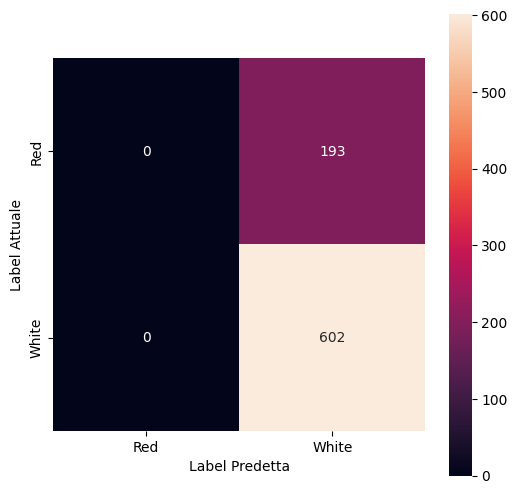

In [ ]:
# Matrice di confusione
# TN FP
# FN TP

# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

In [ ]:
print("Accuracy modello baseline\n")
baseline_test_accuracy = accuracy_score(y_test, y_pred)
print(baseline_test_accuracy)

Accuracy modello baseline

0.7572327044025158


## Rete Neurale





Il primo approccio alla risoluzione del problema di classificazione binaria è stato quello dell'utilizzo delle reti neurali, uno strumento versatile e utilizzabile in moltissimi contesti. Il modello verrà addestrato utilizzando i dati ottenuti dalla PCA.

Sono state costruite in dettaglio due reti neurali:
- La rete "naive", con un approccio semplice ed immediato, utilizzando dati di default per la creazione della rete neurale
- La rete "ottimizzata" con un approccio più complesso, valutando gli iperparametri da utilizzare nella costruzione della rete, al fine di ottimizzare la classificazione.



### Modello approccio "naive"

#### Costruzione modello e stampa struttura

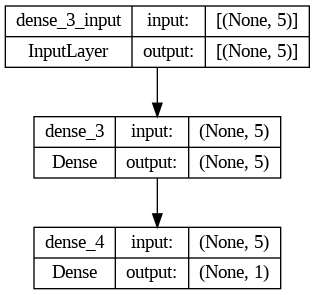

In [ ]:
# Definisco la rete neurale
nn_model_naive = Sequential()

# Una rete con un numero di neuroni iniziali pari al numero delle componenti PCA
nn_model_naive.add(Dense(n_components, input_shape=(n_components,), activation='relu'))
# Un neurone in uscita con funzione di attivazione sigmoide (target binario)
nn_model_naive.add(Dense(1, activation='sigmoid'))

# Compilo il modello
nn_model_naive.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Stampo un plot per la struttura della rete
keras.utils.plot_model(nn_model_naive, show_shapes=True)

#### Training con tempo impiegato




In [ ]:
# Effettuo il training utilizzando validation_data
start_time = time()
# Valori di default
history_naive = nn_model_naive.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_validation, y_validation))
end_time = time()
nn_naive_training_time = end_time - start_time

# Stampa il tempo di training
print(f'Tempo di training Rete Neurale Naive: {nn_naive_training_time:.2f} secondi')

Epoch 1/10
116/116 [==============================] - 1s 4ms/step - loss: 0.6300 - accuracy: 0.6839 - val_loss: 0.5438 - val_accuracy: 0.7434
Epoch 2/10
116/116 [==============================] - 0s 2ms/step - loss: 0.5170 - accuracy: 0.7212 - val_loss: 0.4593 - val_accuracy: 0.7635
Epoch 3/10
116/116 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.7738 - val_loss: 0.3863 - val_accuracy: 0.8226
Epoch 4/10
116/116 [==============================] - 0s 2ms/step - loss: 0.3546 - accuracy: 0.8354 - val_loss: 0.3198 - val_accuracy: 0.8629
Epoch 5/10
116/116 [==============================] - 0s 2ms/step - loss: 0.2911 - accuracy: 0.8694 - val_loss: 0.2660 - val_accuracy: 0.8956
Epoch 6/10
116/116 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.9336 - val_loss: 0.2229 - val_accuracy: 0.9711
Epoch 7/10
116/116 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.9706 - val_loss: 0.1866 - val_accuracy: 0.9761
Epoch 

In [ ]:
# Valutazione accuracy training

print('Training loss:', history_naive.history['loss'][-1])
print('Training accuracy:', history_naive.history['accuracy'][-1])
nn_naive_train_accuracy = history_naive.history['accuracy'][-1]

Training loss: 0.11266162991523743
Training accuracy: 0.9775978326797485


#### Predizioni e matrice di confusione


In [ ]:
# Valuto le prestazioni del modello (Accuracy e Loss)
score_naive = nn_model_naive.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_naive[0])
print('Test accuracy:', score_naive[1])
nn_naive_test_accuracy = score_naive[1]

Test loss: 0.1236429437994957
Test accuracy: 0.9723270535469055


25/25 [==============================] - 0s 1ms/step


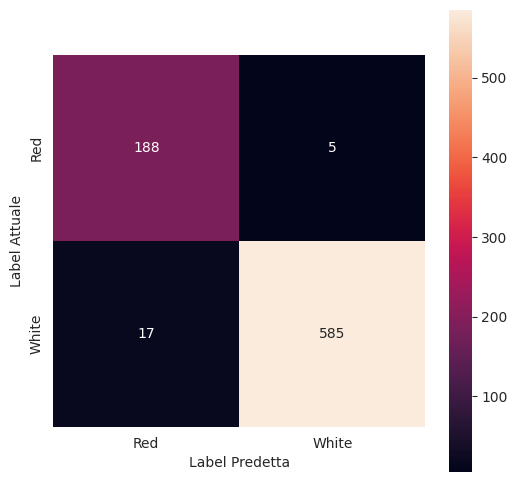

In [ ]:
# Effettuo le predizioni sul modello naive necessarie per le successive analisi
y_pred_naive = nn_model_naive.predict(X_test)
y_pred_naive = np.round(y_pred_naive)

# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_naive)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

#### Performance evaluation

##### Misure per classe target e globali



In [ ]:
# Misure di performance CLASSE

nn_naive_classification_report = classification_report(y_test, y_pred_naive)
print(nn_naive_classification_report)

              precision    recall  f1-score   support

       False       0.92      0.97      0.94       193
        True       0.99      0.97      0.98       602

    accuracy                           0.97       795
   macro avg       0.95      0.97      0.96       795
weighted avg       0.97      0.97      0.97       795



In [ ]:
# Misure di performance GLOBALI

# Valuta il modello utilizzando i dati di test e predicted
accuracy_train_test_naive = accuracy_score(y_test, y_pred_naive)
precision_naive = precision_score(y_test, y_pred_naive)
recall_naive = recall_score(y_test, y_pred_naive)
f1_naive = f1_score(y_test, y_pred_naive)

# Stampa le prestazioni del modello naive
print('Accuracy:', accuracy_train_test_naive)
print('Precision:', precision_naive)
print('Recall:', recall_naive)
print('F1-score:', f1_naive)

nn_naive_global_report = {
    'accuracy': accuracy_train_test_naive,
    'precision': precision_naive,
    'recall': recall_naive,
    'f1-score': f1_naive
}

Accuracy: 0.9723270440251572
Precision: 0.9915254237288136
Recall: 0.9717607973421927
F1-score: 0.9815436241610739


##### Curva ROC e misura AUC


25/25 [==============================] - 0s 1ms/step


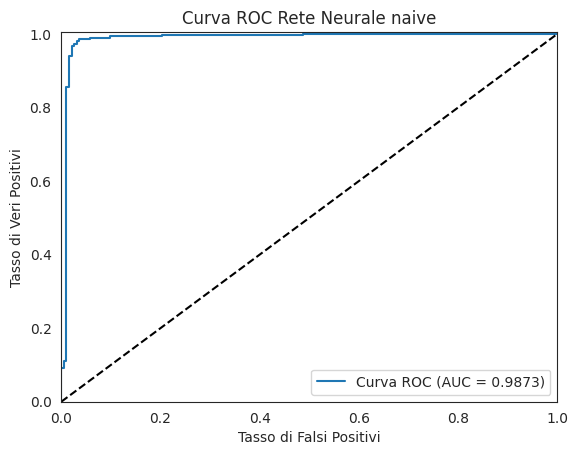

In [ ]:
# Calcola le probabilità di predizione del modello naive
y_pred_prob_naive = nn_model_naive.predict(X_test)

# Calcola la curva ROC
fpr_nn_naive, tpr_nn_naive, _ = roc_curve(y_test, y_pred_prob_naive)

# Calcola l'AUC della curva ROC
roc_auc_nn_naive = roc_auc_score(y_test, y_pred_prob_naive)

# Disegna la curva ROC
plt.plot(fpr_nn_naive, tpr_nn_naive, label='Curva ROC (AUC = %0.4f)' % roc_auc_nn_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC Rete Neurale naive')
plt.legend(loc="lower right")
plt.show()

##### Learning curves per Loss e Accuracy

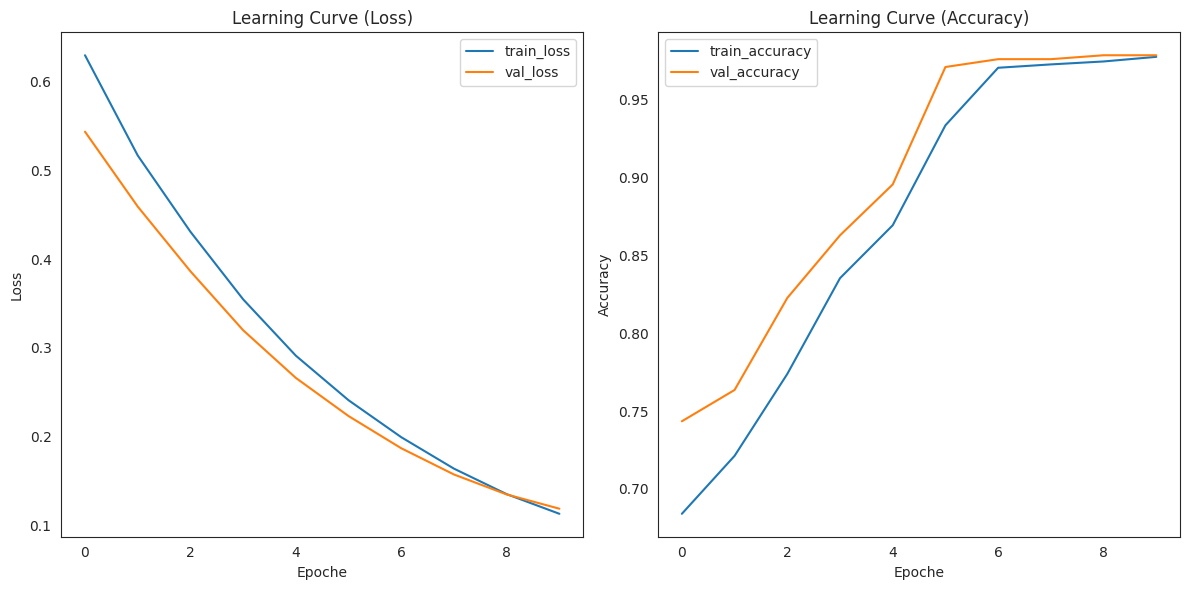

In [ ]:
import matplotlib.pyplot as plt

# Plot loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss
axes[0].plot(history_naive.history['loss'], label='train_loss')
axes[0].plot(history_naive.history['val_loss'], label='val_loss')
axes[0].set_title('Learning Curve (Loss)')
axes[0].set_xlabel('Epoche')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(history_naive.history['accuracy'], label='train_accuracy')
axes[1].plot(history_naive.history['val_accuracy'], label='val_accuracy')
axes[1].set_title('Learning Curve (Accuracy)')
axes[1].set_xlabel('Epoche')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

##### Stratified 10-fold cross validation



In [ ]:
# Un approccio di apprendimento tramite cross validation può migliorare
# la robustezza del modello

# Inizializziamo le liste per memorizzare le misure di valutazione su ogni fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Inizializza la Stratified K-fold Cross-Validation con 10 fold
kf = StratifiedKFold(n_splits=10, shuffle=True)

# Lista per memorizzare le performance di ogni fold
scores = []

# Ciclo attraverso i fold
for train_index, test_index in kf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = np.array(y)[train_index], np.array(y)[test_index]

    # Effettuo il training per ogni fold, no validation data
    nn_model_naive.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)

    # Effettuo le predizioni sul set di test del fold corrente
    y_pred_prob = nn_model_naive.predict(X_test_fold)
    y_pred = np.round(y_pred_prob)

    # Calcolo e memorizzo le misure di valutazione del fold corrente
    accuracy_fold = accuracy_score(y_test_fold, y_pred)
    precision_fold = precision_score(y_test_fold, y_pred)
    recall_fold = recall_score(y_test_fold, y_pred)
    f1_fold = f1_score(y_test_fold, y_pred)

    accuracy_scores.append(accuracy_fold)
    precision_scores.append(precision_fold)
    recall_scores.append(recall_fold)
    f1_scores.append(f1_fold)

# Calcolo le medie delle misure di valutazione su tutti i fold
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Stampo le medie delle misure di valutazione
print('Average Test accuracy:', avg_accuracy)
print('Average Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average F1-score:', avg_f1)

17/17 [==============================] - 0s 1ms/step
Average Test accuracy: 0.9873474337482613
Average Precision: 0.9901436757007952
Average Recall: 0.9928991839619611
Average F1-score: 0.9915136585024815


In [ ]:
# Stampo le scores di ogni fold
print("Scores della Cross validation:")
print("Accuracy: ", accuracy_scores)
print("Precision: ", precision_scores)
print("Recall: ", recall_scores)
print("F1-score: ", f1_scores)

nn_naive_cv_scores = {
    'accuracy': accuracy_scores,
    'precision': precision_scores,
    'recall': recall_scores,
    'f1-score': f1_scores
}

Scores della Cross validation:
Accuracy:  [0.9792452830188679, 0.9886792452830189, 0.9905660377358491, 0.9849056603773585, 0.9886792452830189, 0.9848771266540642, 0.9905482041587902, 0.9924385633270322, 0.994328922495274, 0.9792060491493384]
Precision:  [0.9848484848484849, 0.9949109414758269, 0.9924050632911392, 0.9849246231155779, 0.9923857868020305, 0.9898477157360406, 0.9949109414758269, 0.9899497487437185, 0.9924433249370277, 0.9848101265822785]
Recall:  [0.9873417721518988, 0.9898734177215189, 0.9949238578680203, 0.9949238578680203, 0.9923857868020305, 0.9898477157360406, 0.9923857868020305, 1.0, 1.0, 0.9873096446700508]
F1-score:  [0.986093552465234, 0.9923857868020304, 0.9936628643852978, 0.9898989898989898, 0.9923857868020305, 0.9898477157360406, 0.9936467598475223, 0.9949494949494949, 0.9962073324905183, 0.9860583016476553]


In [ ]:
# Calcolo l'intervallo di confidenza per ciascuna misura di valutazione
accuracy_interval = st.t.interval(confidence=0.95, df=len(accuracy_scores)-1, loc=np.mean(accuracy_scores), scale=st.sem(accuracy_scores))
precision_interval = st.t.interval(confidence=0.95, df=len(precision_scores)-1, loc=np.mean(precision_scores), scale=st.sem(precision_scores))
recall_interval = st.t.interval(confidence=0.95, df=len(recall_scores)-1, loc=np.mean(recall_scores), scale=st.sem(recall_scores))
f1_interval = st.t.interval(confidence=0.95, df=len(f1_scores)-1, loc=np.mean(f1_scores), scale=st.sem(f1_scores))

# Stampo gli intervalli di confidenza
print('95% Intervallo di Confidenza per Accuracy:', accuracy_interval)
print('95% Intervallo di Confidenza per Precision:', precision_interval)
print('95% Intervallo di Confidenza per Recall:', recall_interval)
print('95% Intervallo di Confidenza per F1-score:', f1_interval)

nn_naive_95_conf = {
    'accuracy': accuracy_interval,
    'precision': precision_interval,
    'recall': recall_interval,
    'f1-score': f1_interval
}

95% Intervallo di Confidenza per Accuracy: (0.983631827801799, 0.9910630396947235)
95% Intervallo di Confidenza per Precision: (0.987274979835195, 0.9930123715663954)
95% Intervallo di Confidenza per Recall: (0.9896109324744412, 0.996187435449481)
95% Intervallo di Confidenza per F1-score: (0.989023607185842, 0.994003709819121)


### Hyperparameter tuning

#### Costruzione della Rete Neurale "ottimale"

In [ ]:
# Andiamo a costruire un modello che minimizzi la loss, data l'altissima accuracy
# già presente nella rete naive.

# Funzione per la definizione del modello
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(n_components,)))
    # Cerco un layer ottimale da 1 a 4 hidden
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=512, step=32), activation='relu'))
        # Layer di dropout per ridurre overfitting
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    # Cerco un learning_rate ottimale
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # Compilo il modello
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Definisco il tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss', # Obiettivo val_loss
                     max_epochs=10,
                     factor=3,
                     directory='project',
                     overwrite=True, # Ignora il salvataggio su directory
                     project_name='nn_model_hp')

# Mi fermo prima se la var_loss peggiora
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# Eseguo la ricerca degli iperparametri con massimo 10 epoche
tuner.search(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), callbacks=[stop_early])
# Ottengo i miglior iperparametri
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Miglior Iperparametri per la Rete Neurale:")
print("Units: " , best_hps.get('units'))
print("Layers: " , best_hps.get('num_layers'))
print("Learning Rate: " , best_hps.get('learning_rate'))


Trial 30 Complete [00h 00m 15s]
val_loss: 0.13275210559368134

Best val_loss So Far: 0.06649835407733917
Total elapsed time: 00h 03m 21s
Miglior Iperparametri per la Rete Neurale:
Units:  448
Layers:  1
Learning Rate:  0.001


#### Calcolo della miglior Epoca

In [ ]:
# Ottengo il modello ottimale
models = tuner.get_best_models(num_models=1)
model = models[0]

# Alleno il modello su 10 epoche, al fine di trovarne la migliore
history_hp = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation))

val_acc_per_epoch = history_hp.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Miglior epoch: %d' % (best_epoch,))

Epoch 1/10
116/116 [==============================] - 1s 5ms/step - loss: 0.0406 - accuracy: 0.9892 - val_loss: 0.0756 - val_accuracy: 0.9862
Epoch 2/10
116/116 [==============================] - 0s 3ms/step - loss: 0.0368 - accuracy: 0.9903 - val_loss: 0.0716 - val_accuracy: 0.9874
Epoch 3/10
116/116 [==============================] - 1s 5ms/step - loss: 0.0373 - accuracy: 0.9906 - val_loss: 0.0675 - val_accuracy: 0.9887
Epoch 4/10
116/116 [==============================] - 1s 5ms/step - loss: 0.0349 - accuracy: 0.9897 - val_loss: 0.0768 - val_accuracy: 0.9874
Epoch 5/10
116/116 [==============================] - 1s 5ms/step - loss: 0.0342 - accuracy: 0.9908 - val_loss: 0.0742 - val_accuracy: 0.9862
Epoch 6/10
116/116 [==============================] - 1s 5ms/step - loss: 0.0353 - accuracy: 0.9914 - val_loss: 0.0769 - val_accuracy: 0.9862
Epoch 7/10
116/116 [==============================] - 1s 5ms/step - loss: 0.0337 - accuracy: 0.9908 - val_loss: 0.0745 - val_accuracy: 0.9874
Epoch 

### Modello ottimale

#### Training con tempo impiegato e stampa struttura

Epoch 1/3
116/116 [==============================] - 1s 5ms/step - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.0708 - val_accuracy: 0.9862
Epoch 2/3
116/116 [==============================] - 0s 3ms/step - loss: 0.0379 - accuracy: 0.9903 - val_loss: 0.0722 - val_accuracy: 0.9874
Epoch 3/3
116/116 [==============================] - 0s 3ms/step - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.0907 - val_accuracy: 0.9836
Tempo di training Rete Neurale Ottimale: 2.28 secondi


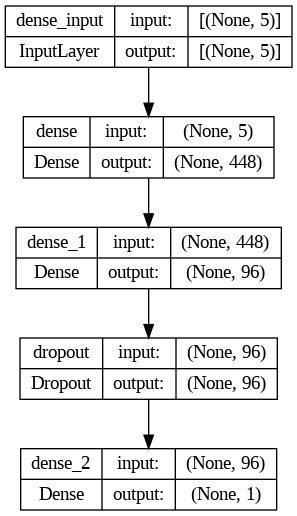

In [ ]:
# Ottengo il modello ottimale
models = tuner.get_best_models(num_models=1)
nn_model_hp  = models[0]

# Rialleno il modello ottimale
start_time = time()
history_hp = nn_model_hp.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_validation, y_validation))
end_time = time()
nn_hp_training_time = end_time - start_time

# Stampa il tempo di training del modello ottimale
print(f'Tempo di training Rete Neurale Ottimale: {nn_hp_training_time:.2f} secondi')

# Stampo un plot per la struttura della rete
keras.utils.plot_model(nn_model_hp, show_shapes=True)
# Abbiamo quindi oltre al layer di input (i primi due) e output
# dei hidden layer pari a num_layers ottenuti dal tuner * 2 (i layer di dropout)

In [ ]:
# Valutazione accuracy training

print('Training loss:', history_hp.history['loss'][-1])
print('Training accuracy:', history_hp.history['accuracy'][-1])
nn_hp_train_accuracy = history_hp.history['accuracy'][-1]

Training loss: 0.035086289048194885
Training accuracy: 0.9900134801864624


#### Predizioni e matrice di confusione


In [ ]:
# Valuto le prestazioni del modello (Accuracy e Loss)
score_hp = nn_model_hp.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score_hp[0])
print('Test accuracy:', score_hp[1])
nn_hp_test_accuracy = score_hp[1]

Test loss: 0.06548423320055008
Test accuracy: 0.9823899269104004


25/25 [==============================] - 0s 1ms/step


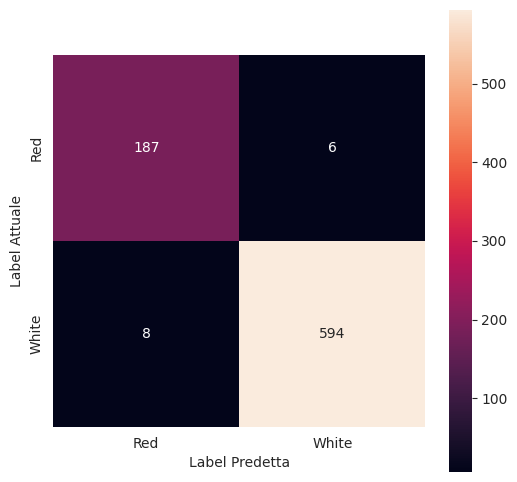

In [ ]:
# Effettuo le predizioni sul modello ottimale necessarie per le successive analisi
y_pred_hp = nn_model_hp.predict(X_test)
y_pred_hp = np.round(y_pred_hp)

# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_hp)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

#### Performance evaluation

##### Misure per classe target e globali

In [ ]:
# Misure di performance CLASSE
nn_hp_classification_report = classification_report(y_test, y_pred_hp)
print(nn_hp_classification_report)

              precision    recall  f1-score   support

       False       0.96      0.97      0.96       193
        True       0.99      0.99      0.99       602

    accuracy                           0.98       795
   macro avg       0.97      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



In [ ]:
# Misure di performance GLOBALI

# Valuta il modello ottimale utilizzando i dati di test e predicted
accuracy_train_test_hp = accuracy_score(y_test, y_pred_hp)
precision_hp = precision_score(y_test, y_pred_hp)
recall_hp = recall_score(y_test, y_pred_hp)
f1_hp = f1_score(y_test, y_pred_hp)

# Stampa le prestazioni del modello
print('Accuracy:', accuracy_train_test_hp)
print('Precision:', precision_hp)
print('Recall:', recall_hp)
print('F1-score:', f1_hp)

nn_hp_global_report = {
    'accuracy': accuracy_train_test_hp,
    'precision': precision_hp,
    'recall': recall_hp,
    'f1-score': f1_hp
}

Accuracy: 0.9823899371069182
Precision: 0.99
Recall: 0.9867109634551495
F1-score: 0.9883527454242927


##### Curva ROC e misura AUC


25/25 [==============================] - 0s 2ms/step


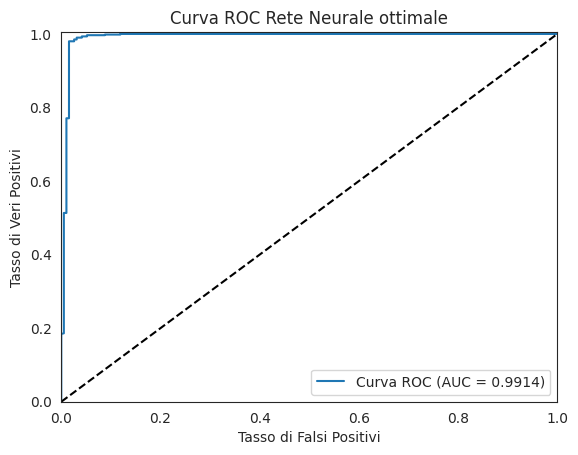

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcola le probabilità di predizione del modello ottimale
y_pred_prob_hp = nn_model_hp.predict(X_test)

# Calcola la curva ROC
fpr_nn_hp, tpr_nn_hp, _ = roc_curve(y_test, y_pred_prob_hp)

# Calcola l'AUC della curva ROC
roc_auc_nn_hp = roc_auc_score(y_test, y_pred_prob_hp)

# Disegna la curva ROC
plt.plot(fpr_nn_hp, tpr_nn_hp, label='Curva ROC (AUC = %0.4f)' % roc_auc_nn_hp)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC Rete Neurale ottimale')
plt.legend(loc="lower right")
plt.show()

##### Learning curves per Loss e Accuracy "ottimale", comparata con quella "naive"

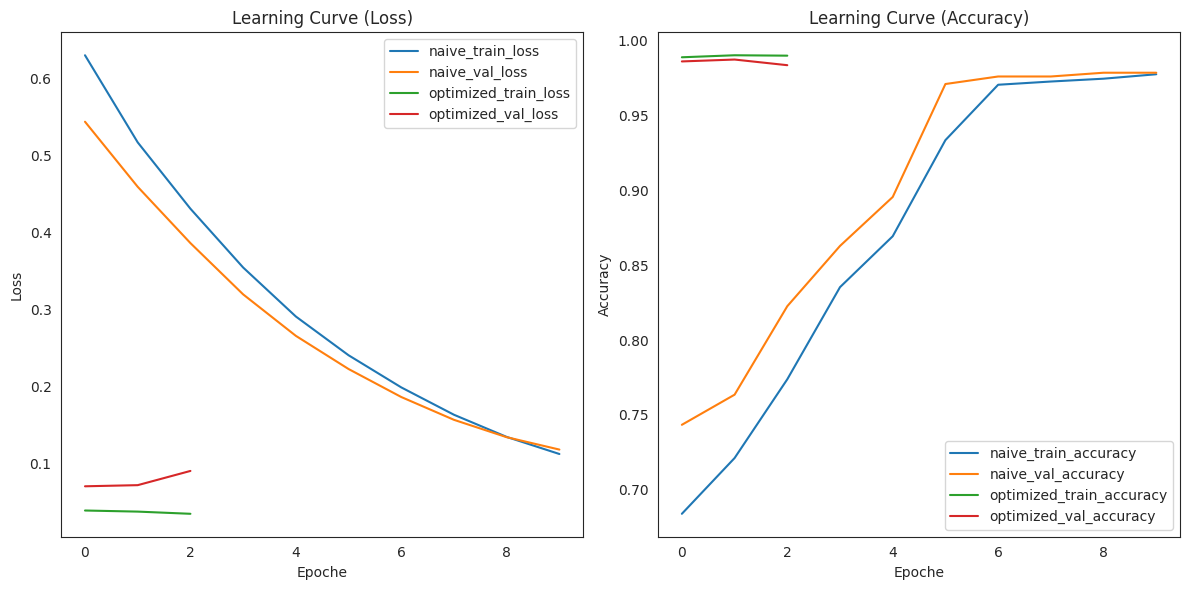

In [ ]:
# Compariamo adesso il modello naive con quello ottimizzato
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot della loss dei modelli
axes[0].plot(history_naive.history['loss'], label='naive_train_loss')
axes[0].plot(history_naive.history['val_loss'], label='naive_val_loss')
axes[0].plot(history_hp.history['loss'], label='optimized_train_loss')
axes[0].plot(history_hp.history['val_loss'], label='optimized_val_loss')
axes[0].set_title('Learning Curve (Loss)')
axes[0].set_xlabel('Epoche')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot dell'accuracy dei modelli
axes[1].plot(history_naive.history['accuracy'], label='naive_train_accuracy')
axes[1].plot(history_naive.history['val_accuracy'], label='naive_val_accuracy')
axes[1].plot(history_hp.history['accuracy'], label='optimized_train_accuracy')
axes[1].plot(history_hp.history['val_accuracy'], label='optimized_val_accuracy')
axes[1].set_title('Learning Curve (Accuracy)')
axes[1].set_xlabel('Epoche')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Possiamo notare un leggerissimo, trascurabile overfitting sul grafico della loss
# Mentre abbiamo un incremento dell'accuracy

##### Stratified 10-fold cross validation



In [ ]:
# Cross Validation: Il nostro dataset può essere considerato piccolo
# un approccio di apprendimento tramite cross validation può migliorare
# la robustezza del modello

# Inizializziamo le liste per memorizzare le misure di valutazione su ogni fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Inizializza la Stratified K-fold Cross-Validation con 10 fold
n_fold = 10
kf = StratifiedKFold(n_splits=n_fold, shuffle=True)

# Lista per memorizzare le performance di ogni fold
scores = []

# Ciclo attraverso i fold
for train_index, test_index in kf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = np.array(y)[train_index], np.array(y)[test_index]

    # Effettuo il training per ogni fold, no validation data
    nn_model_hp.fit(X_train_fold, y_train_fold, epochs=best_epoch, batch_size=32, verbose=0)

    # Effettuo le predizioni sul set di test del fold corrente
    y_pred_prob = nn_model_hp.predict(X_test_fold)
    y_pred = np.round(y_pred_prob)

    # Calcolo e memorizzo le misure di valutazione del fold corrente
    accuracy_fold = accuracy_score(y_test_fold, y_pred)
    precision_fold = precision_score(y_test_fold, y_pred)
    recall_fold = recall_score(y_test_fold, y_pred)
    f1_fold = f1_score(y_test_fold, y_pred)

    accuracy_scores.append(accuracy_fold)
    precision_scores.append(precision_fold)
    recall_scores.append(recall_fold)
    f1_scores.append(f1_fold)

# Calcolo le medie delle misure di valutazione su tutti i fold
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

# Stampo le medie delle misure di valutazione
print('Average Test accuracy:', avg_accuracy)
print('Average Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average F1-score:', avg_f1)

17/17 [==============================] - 0s 2ms/step
Average Test accuracy: 0.9896133680493632
Average Precision: 0.9916923564190794
Average Recall: 0.9944181713037331
Average F1-score: 0.9930354004927038


In [ ]:
# Stampo le scores dei singoli fold
print("Scores della Cross validation:")
print("Accuracy: ", accuracy_scores)
print("Precision: ", precision_scores)
print("Recall: ", recall_scores)
print("F1-score: ", f1_scores)

nn_hp_cv_scores = {
    'accuracy': accuracy_scores,
    'precision': precision_scores,
    'recall': recall_scores,
    'f1-score': f1_scores
}

Scores della Cross validation:
Accuracy:  [0.9886792452830189, 0.9867924528301887, 0.9905660377358491, 0.9867924528301887, 0.9924528301886792, 0.9848771266540642, 0.996219281663516, 0.9924385633270322, 0.9905482041587902, 0.9867674858223062]
Precision:  [0.9899244332493703, 0.985, 0.9874686716791979, 0.9898734177215189, 0.9974489795918368, 0.9849246231155779, 0.9974619289340102, 0.9899497487437185, 0.9974424552429667, 0.9974293059125964]
Recall:  [0.9949367088607595, 0.9974683544303797, 1.0, 0.9923857868020305, 0.9923857868020305, 0.9949238578680203, 0.9974619289340102, 1.0, 0.9898477157360406, 0.9847715736040609]
F1-score:  [0.9924242424242423, 0.9911949685534591, 0.9936948297604036, 0.991128010139417, 0.994910941475827, 0.9898989898989898, 0.9974619289340102, 0.9949494949494949, 0.9936305732484076, 0.991060025542784]


In [ ]:
# Calcolo l'intervallo di confidenza per ciascuna misura di valutazione
accuracy_interval = st.t.interval(confidence=0.95, df=len(accuracy_scores)-1, loc=np.mean(accuracy_scores), scale=st.sem(accuracy_scores))
precision_interval = st.t.interval(confidence=0.95, df=len(precision_scores)-1, loc=np.mean(precision_scores), scale=st.sem(precision_scores))
recall_interval = st.t.interval(confidence=0.95, df=len(recall_scores)-1, loc=np.mean(recall_scores), scale=st.sem(recall_scores))
f1_interval = st.t.interval(confidence=0.95, df=len(f1_scores)-1, loc=np.mean(f1_scores), scale=st.sem(f1_scores))

# Stampo gli intervalli di confidenza
print('95% Intervallo di Confidenza per Accuracy:', accuracy_interval)
print('95% Intervallo di Confidenza per Precision:', precision_interval)
print('95% Intervallo di Confidenza per Recall:', recall_interval)
print('95% Intervallo di Confidenza per F1-score:', f1_interval)

nn_hp_95_conf = {
    'accuracy': accuracy_interval,
    'precision': precision_interval,
    'recall': recall_interval,
    'f1-score': f1_interval
}

95% Intervallo di Confidenza per Accuracy: (0.9871263367712374, 0.992100399327489)
95% Intervallo di Confidenza per Precision: (0.9879198101196058, 0.9954649027185529)
95% Intervallo di Confidenza per Recall: (0.9910156200006519, 0.9978207226068143)
95% Intervallo di Confidenza per F1-score: (0.9913713064260453, 0.9946994945593622)


## SVM

Viene utilizzato il modello SVM perché osservando lo scatterplot delle prime due componenti di PCA, mostrato in precedenza, si potrebbe pensare di separare le due classi red e white attraverso un iperpiano separatore. Si tratta di una intuizione, in quanto in realtà il modello viene allenato su 5 dimensioni (feature extraction ottenuta dalla PCA).

Si allena innanzitutto un modello "naive" (con kernel lineare così è possibile anche plottare la relativa feature extraction in 3 dimensioni, naturalmente si perdono informazioni siccome il modello non è allenato in 3 dimensioni ma su 5) e in seguito si effettua hyperparameters tuning (sfruttando il validation set), con l'ottimizzazione della accuracy, per trattare il modello con accuracy max.

### Modello approccio "naive"

#### Training con tempo impiegato e num. vettori di supporto

In [ ]:
# Addestramento modello SVM "naive" (con kernel linear) e calcolo tempo impiegato
start_time = time()
svm_model = svm.SVC(kernel='linear', random_state=42)
estimator_svm = svm_model.fit(X_train, y_train)
end_time = time()
svm_training_time = end_time - start_time
print("Tempo training SVM in secondi:", round(svm_training_time, 4))
print()
print("Numero vettori di supporto:", svm_model.support_vectors_.shape[0])

Tempo training SVM in secondi: 0.0521

Numero vettori di supporto: 175


In [ ]:
# Valutazione accuracy training

y_pred = svm_model.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred))
svm_naive_train_accuracy = accuracy_score(y_train, y_pred)

Training accuracy: 0.9854251012145749


#### Visualizzazione 3D (modello allenato in 5 dimensioni)

In [ ]:
# Dimensionality reduction per visualizzare i dati

# Naturalmente si perdono informazioni (siccome il modello è allenato su 5 dimensioni),
# ma non si riesce a mostrare più di 3 dimensioni

pca_train_3D = PCA(n_components=3).fit(X_train)
X_train_3D = pca_train_3D.transform(X_train)

w: [ 2.42072269 -0.39061619  0.15219564]
w_hat: [ 0.98533356 -0.15899683  0.06194988]
b: 2.4611
Iperpiano: 2.4207 * x -0.3906 * y + 0.1522 * z + 2.4611 = 0
Magnitudine margine: 0.407


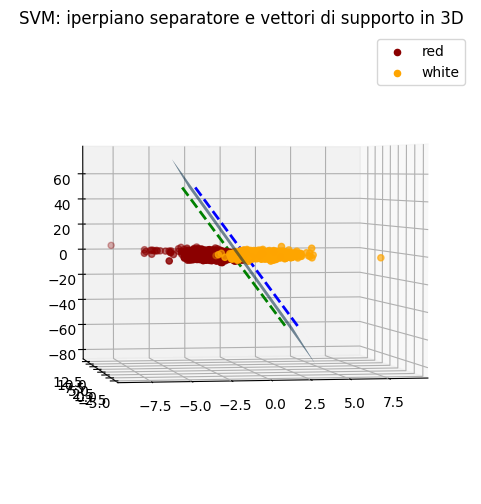

In [ ]:
# In 3D l'iperpiano è dato da
# w_0 * x + w_1 * y + w_2 * z + b = 0
# Cioè z = (-b - w_0 * x - w_1 * y) / w_2
w = svm_model.coef_[0]
w = w[:-2] # da shape (5,) a (3,)
w_hat = w / (np.sqrt(np.sum(w ** 2)))
b = svm_model.intercept_[0]
hyperplane = lambda x,y: (-b - w[0] * x - w[1] * y) / w[2]
print('w:', w)
print('w_hat:', w_hat) # vettore unitario che dà la direzione dell'iperpiano
print('b:', round(b, 4))
print("Iperpiano:", round(w[0], 4), "* x", round(w[1], 4), "* y +", round(w[2], 4), "* z +", round(b, 4), "= 0")

# Figura 3D
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
plt.title('SVM: iperpiano separatore e vettori di supporto in 3D')

# Iperpiano
xx = np.linspace(-5, 3)
tmp_x, tmp_y = np.meshgrid(xx, xx)
z = hyperplane(tmp_x, tmp_y)
ax.plot_surface(tmp_x, tmp_y, z, alpha=0.8)

# Punti corrispondenti ai vettori di supporto
yy = xx
zz = hyperplane(xx, yy)

# Margine e vettori di supporto
margin = 1 / np.sqrt(np.sum(w ** 2))
print('Magnitudine margine:', round(margin, 4))
decision_boundary_points = np.array(list(zip(xx, yy, zz)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin

# Plot vettori di supporto
ax.plot(points_of_line_above[:, 0],
        points_of_line_above[:, 1],
        points_of_line_above[:, 2],
        'b--', linewidth=2)
ax.plot(points_of_line_below[:, 0],
        points_of_line_below[:, 1],
        points_of_line_below[:, 2],
        'g--', linewidth=2)

# Dati di training in 3D
ax.scatter(X_train_3D[y_train == False, 0], X_train_3D[y_train == False, 1], X_train_3D[y_train == False, 2], c='darkred', label='red')
ax.scatter(X_train_3D[y_train == True, 0], X_train_3D[y_train == True, 1], X_train_3D[y_train == True, 2], c='orange', label='white')

# Visualizzo il plot
ax.view_init(2, 260)
ax.legend()
plt.show()

#### Predizioni e matrice di confusione



In [ ]:
# Predizione sui dati di test

y_pred = svm_model.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
svm_naive_test_accuracy = accuracy_score(y_test, y_pred)

Test accuracy: 0.9861635220125786


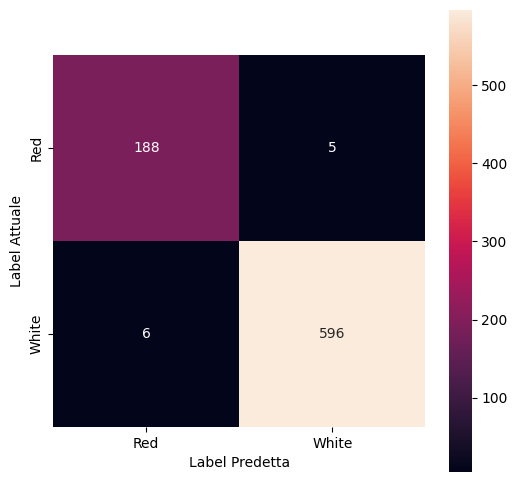

In [ ]:
# Matrice di confusione
# TN FP
# FN TP

# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

#### Performance evaluation


##### Misure per classe target e globali



In [ ]:
# Misure di performance a livello di CLASSE

print("Misure di performance SVM a livello di classe\n")
svm_naive_classification_report = classification_report(y_test, y_pred)
print(svm_naive_classification_report)


# Va bene macro avg nel nostro caso, non c'è una classe più importante

Misure di performance SVM a livello di classe

              precision    recall  f1-score   support

       False       0.97      0.97      0.97       193
        True       0.99      0.99      0.99       602

    accuracy                           0.99       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.99      0.99      0.99       795



In [ ]:
# Misure di performance GLOBALI

print("Misure di performance SVM globali\n")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))

svm_naive_global_report = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1-score': f1_score(y_test, y_pred)
}

Misure di performance SVM globali

Accuracy: 0.9861635220125786
Precision: 0.9916805324459235
Recall: 0.9900332225913622
F1-score: 0.9908561928512053


##### Curva ROC e misura AUC



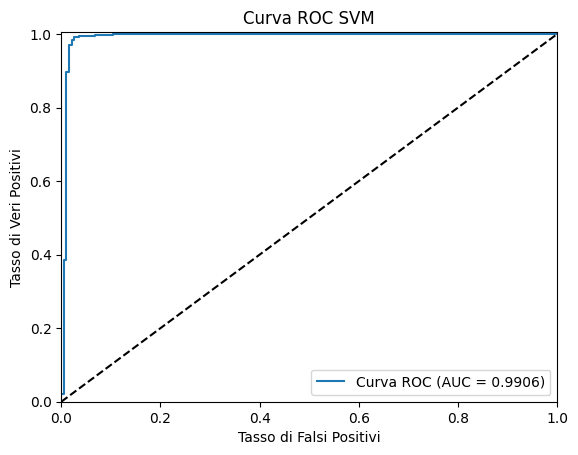

In [ ]:
# Calcola le probabilità di predizione del modello
prob_svm_model = svm.SVC(kernel='linear', random_state=42, probability=True)
prob_svm_model.fit(X_train, y_train)
y_pred_proba = prob_svm_model.predict_proba(X_test)
y_pred_prob = y_pred_proba[:, 1]

# Calcola la curva ROC
fpr_svm_naive, tpr_svm_naive, _ = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC della curva ROC
roc_auc_svm_naive = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.plot(fpr_svm_naive, tpr_svm_naive, label='Curva ROC (AUC = %0.4f)' % roc_auc_svm_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC SVM')
plt.legend(loc="lower right")
plt.show()

##### Stratified 10-fold cross validation



In [ ]:
# Stratified 10-fold cross validation
print("Risultati SVM stratified 10-fold cross validation\n\n")
cv_dict = my_cross_validation(svm.SVC(kernel='linear', random_state=42))

svm_naive_cv_scores = cv_dict['scores']
svm_naive_95_conf = cv_dict['95_conf']

Risultati SVM stratified 10-fold cross validation


--- Accuracy di ogni fold, con media pari a 0.98432643 ---

[0.97924528 0.98113208 0.98113208 0.98490566 0.98679245 0.97920605
 0.99432892 0.98109641 0.98109641 0.99432892]

Intervallo di confidenza 95%: (0.9801975036859518, 0.9884553479030198)


--- Precision di ogni fold, con media pari a 0.9793808 ---

[0.971596   0.97301313 0.97527247 0.98488655 0.97945684 0.97374835
 0.99373701 0.97097399 0.97738665 0.99373701]

Intervallo di confidenza 95%: (0.9732227955478482, 0.985538805415224)


--- Recall di ogni fold, con media pari a 0.97952412 ---

[0.97388654 0.97759025 0.97527247 0.97540311 0.98630188 0.9714326
 0.99132356 0.98000564 0.97270164 0.99132356]

Intervallo di confidenza 95%: (0.9741537898588039, 0.9848944579895299)


--- F1_score di ogni fold, con media pari a 0.97941339 ---

[0.97273395 0.97527247 0.97527247 0.98002412 0.98281413 0.97258305
 0.99252265 0.97537427 0.97501417 0.99252265]

Intervallo di confidenza 95%: (0.9739

### Hyperparameter tuning

#### Grid search iperparametri C, kernel e gamma massimizzando accuracy

In [ ]:
# Tuning degli iperparametri C, kernel e gamma

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.001, 0.0001, 0.00001],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [0.01, 0.001, 0.0001, 0.00001],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]

# Con la grid search ottimizzo l'accuracy ma si potrebbe cambiare
grid = GridSearchCV(svm.SVC(random_state=42), tuned_parameters, verbose=3, scoring='accuracy')
grid.fit(X_train_validation, y_train_validation)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.742 total time=   1.2s
[CV 2/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.742 total time=   1.3s
[CV 3/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.742 total time=   0.9s
[CV 4/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.742 total time=   0.4s
[CV 5/5] END ...C=0.001, gamma=0.01, kernel=rbf;, score=0.742 total time=   0.4s
[CV 1/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.742 total time=   0.4s
[CV 2/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.742 total time=   0.6s
[CV 3/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.742 total time=   0.7s
[CV 4/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.742 total time=   0.6s
[CV 5/5] END ..C=0.001, gamma=0.001, kernel=rbf;, score=0.742 total time=   0.6s
[CV 1/5] END .C=0.001, gamma=0.0001, kernel=rbf;, score=0.742 total time=   0.6s
[CV 2/5] END .C=0.001, gamma=0.0001, kernel=rbf

GridSearchCV(estimator=SVC(random_state=42),
             param_grid=[{'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['rbf']},
                         {'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000],
                          'gamma': [0.01, 0.001, 0.0001, 1e-05],
                          'kernel': ['sigmoid']},
                         {'C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000],
                          'kernel': ['linear']}],
             scoring='accuracy', verbose=3)

In [ ]:
# Stampa degli iperparametri ottimali
print("Iperparametri ottimali:", grid.best_params_)

Iperparametri ottimali: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


### Modello ottimale

#### Training con tempo impiegato e num. vettori di supporto

In [ ]:
# Addestramento modello SVM ottimale e calcolo tempo impiegato
start_optimal_time = time()
svm_optimal_model = svm.SVC(**grid.best_params_, random_state=42)
estimator_svm_optimal = svm_optimal_model.fit(X_train, y_train)
end_optimal_time = time()
svm_optimal_training_time = end_optimal_time - start_optimal_time
print("Tempo training SVM ottimale in secondi:", round(svm_optimal_training_time, 4))
print()
print("Numero vettori di supporto:", svm_optimal_model.support_vectors_.shape[0])

Tempo training SVM ottimale in secondi: 0.0591

Numero vettori di supporto: 150


In [ ]:
# Valutazione accuracy training

y_pred_optimal = svm_optimal_model.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred_optimal))
svm_opt_train_accuracy = accuracy_score(y_train, y_pred_optimal)

Training accuracy: 0.9894736842105263


#### Predizioni e matrice di confusione

In [ ]:
# Predizione sui dati di test

y_pred_optimal = svm_optimal_model.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_optimal))
svm_opt_test_accuracy = accuracy_score(y_test, y_pred_optimal)

Test accuracy: 0.9874213836477987


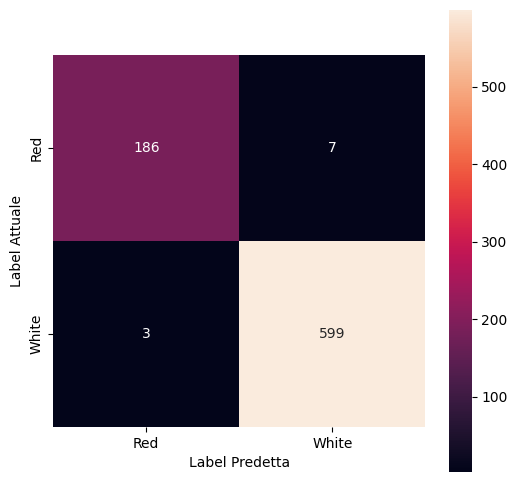

In [ ]:
# Matrice di confusione
# TN FP
# FN TP

# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_optimal)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

#### Performance evaluation

##### Misure per classe target e globali

In [ ]:
# Misure di performance a livello di CLASSE

print("Misure di performance SVM ottimale a livello di classe\n")
svm_opt_classification_report = classification_report(y_test, y_pred_optimal)
print(svm_opt_classification_report)

# Va bene macro avg nel nostro caso, non c'è una classe più importante

Misure di performance SVM ottimale a livello di classe

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       193
        True       0.99      1.00      0.99       602

    accuracy                           0.99       795
   macro avg       0.99      0.98      0.98       795
weighted avg       0.99      0.99      0.99       795



In [ ]:
# Misure di performance GLOBALI

print("Misure di performance SVM ottimale globali\n")
print('Accuracy:', accuracy_score(y_test, y_pred_optimal))
print('Precision:', precision_score(y_test, y_pred_optimal))
print('Recall:', recall_score(y_test, y_pred_optimal))
print('F1-score:', f1_score(y_test, y_pred_optimal))

svm_opt_global_report = {
    'accuracy': accuracy_score(y_test, y_pred_optimal),
    'precision': precision_score(y_test, y_pred_optimal),
    'recall': recall_score(y_test, y_pred_optimal),
    'f1-score': f1_score(y_test, y_pred_optimal)
}

Misure di performance SVM ottimale globali

Accuracy: 0.9874213836477987
Precision: 0.9884488448844885
Recall: 0.9950166112956811
F1-score: 0.9917218543046359


##### Curva ROC e misura AUC

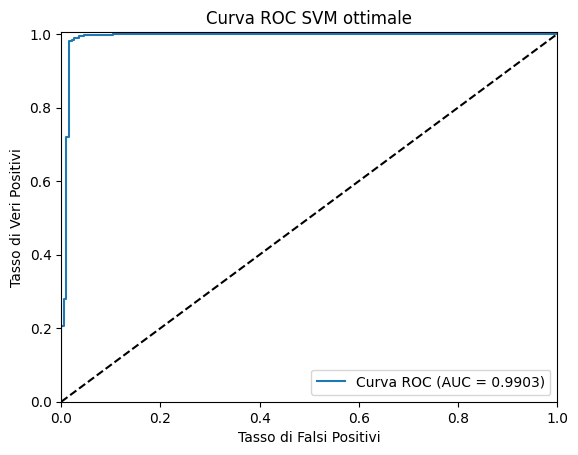

In [ ]:
# Calcola le probabilità di predizione del modello
prob_svm_optimal_model = svm.SVC(**grid.best_params_, random_state=42, probability=True)
prob_svm_optimal_model.fit(X_train, y_train)
y_pred_optimal_prob = prob_svm_optimal_model.predict_proba(X_test)[:, 1]

# Calcola la curva ROC
fpr_svm_opt, tpr_svm_opt, _ = roc_curve(y_test, y_pred_optimal_prob)

# Calcola l'AUC della curva ROC
roc_auc_svm_opt = roc_auc_score(y_test, y_pred_optimal_prob)

# Disegna la curva ROC
plt.plot(fpr_svm_opt, tpr_svm_opt, label='Curva ROC (AUC = %0.4f)' % roc_auc_svm_opt)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC SVM ottimale')
plt.legend(loc="lower right")
plt.show()

##### Learning curves modello "naive" e ottimale



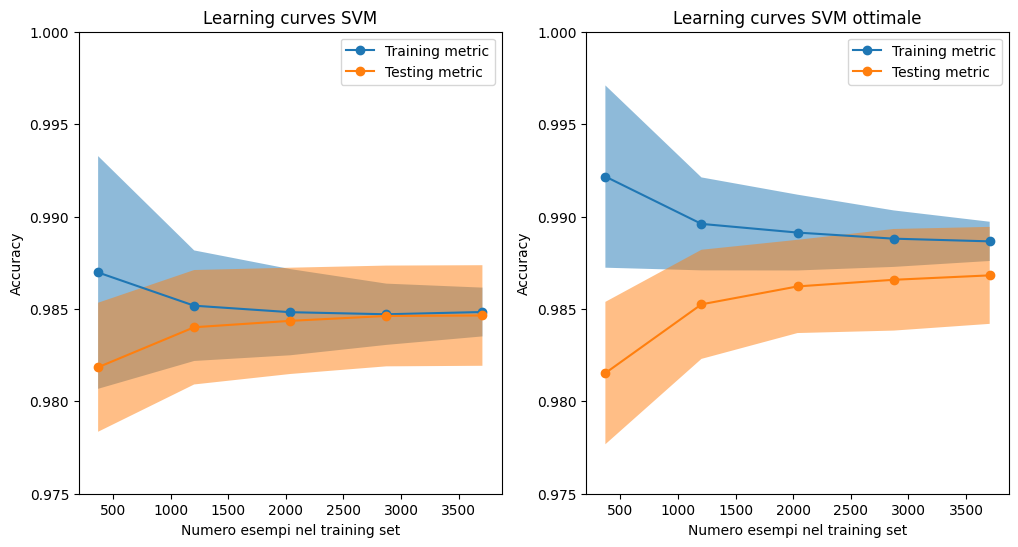

In [ ]:
# Confronto learning curves SVM e SVM ottimale
# In relazione parlare di possibile overfitting per quello ottimale

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

common_params = {
    "X": X,
    "y": y,
    "cv": ShuffleSplit(n_splits=100, test_size=0.3, random_state=42),
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "score_name": "Accuracy",
    "score_type": "both"
}

LearningCurveDisplay.from_estimator(estimator_svm, **common_params, ax=axes[0])
LearningCurveDisplay.from_estimator(estimator_svm_optimal, **common_params, ax=axes[1])

axes[0].set_ylim([0.975, 1.0])
axes[1].set_ylim([0.975, 1.0])

axes[0].set_xlabel("Numero esempi nel training set")
axes[1].set_xlabel("Numero esempi nel training set")

axes[0].set_title("Learning curves SVM")
axes[1].set_title("Learning curves SVM ottimale")

plt.show()

##### Stratified 10-fold cross validation



In [ ]:
# Stratified 10-fold cross validation
print("Risultati SVM ottimale stratified 10-fold cross validation\n\n")
cv_dict = my_cross_validation(svm.SVC(**grid.best_params_, random_state=42))

svm_opt_cv_scores = cv_dict['scores']
svm_opt_95_conf = cv_dict['95_conf']

Risultati SVM ottimale stratified 10-fold cross validation


--- Accuracy di ogni fold, con media pari a 0.98715804 ---

[0.98679245 0.98867925 0.98490566 0.98301887 0.99056604 0.98298677
 0.97731569 0.9905482  0.99243856 0.99432892]

Intervallo di confidenza 95%: (0.9834536695588904, 0.9908624127609015)


--- Precision di ogni fold, con media pari a 0.98408339 ---

[0.98375547 0.98744342 0.97805753 0.98359448 0.98650657 0.97874551
 0.97016356 0.98873985 0.99245272 0.99137479]

Intervallo di confidenza 95%: (0.9791909523558321, 0.9889758275672732)


--- Recall di ogni fold, con media pari a 0.98215311 ---

[0.98138772 0.98265354 0.98262541 0.97172663 0.98883995 0.97640534
 0.97016356 0.98635082 0.98761985 0.99375823]

Intervallo di confidenza 95%: (0.9767498827275306, 0.9875563281516607)


--- F1_score di ogni fold, con media pari a 0.98308658 ---

[0.98256407 0.98501809 0.9803124  0.97747141 0.98766587 0.97756795
 0.97016356 0.98753775 0.99000567 0.99255897]

Intervallo di confidenza 

## Albero Decisionale

Come terzo e ultimo modello è stato scelto l'Albero Decisionale perché è un modello che si presta bene per classificazioni in cui il target assume valori discreti (in particolare qui assume valori binari, concept learning) e per la semplicità e il ridotto tempo di addestramento, rispetto ad altri modelli.

### Modello approccio "naive"

#### Training con tempo impiegato

In [ ]:
# Addestramento modello Albero Decisionale "naive" e calcolo tempo impiegato
start_time = time()
dtc_model = DecisionTreeClassifier(random_state=42)
estimator_dtc = dtc_model.fit(X_train, y_train)
end_time = time()
dtc_training_time = end_time - start_time
print("Tempo training Albero Decisionale in secondi:", round(dtc_training_time, 4))

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(dtc_model, filled=True, ax=ax)
plt.plot()

Tempo training Albero Decisionale in secondi: 0.0209


[]

In [ ]:
# Valutazione accuracy training

y_pred = dtc_model.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred))
dtc_naive_train_accuracy = accuracy_score(y_train, y_pred)

Training accuracy: 1.0


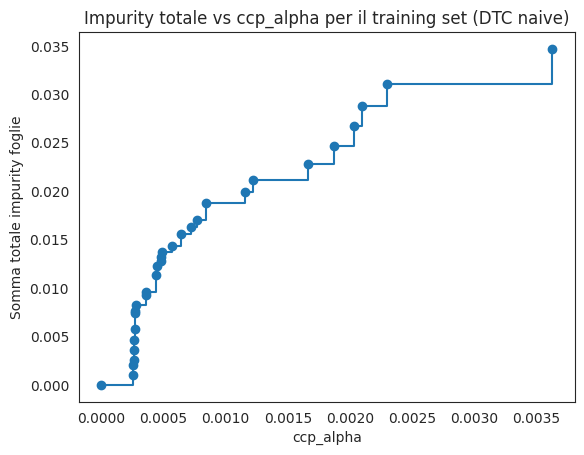

In [ ]:
# Plot grafico impurity vs ccp_alpha
# Qui viene escluso l'ultimo alpha poiché corrisponde al nodo radice

path = dtc_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Somma totale impurity foglie")
ax.set_title("Impurity totale vs ccp_alpha per il training set (DTC naive)");

In [ ]:
# Valore ccp_alpha più alto, corrispondente all'albero con solo radice

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42,ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("(DTC naive) Numero nodi albero: {} con ccp_alpha: {} e profondità: {}".format(
clfs[-1].tree_.node_count, ccp_alphas[-1], clfs[-1].tree_.max_depth))

(DTC naive) Numero nodi albero: 1 con ccp_alpha: 0.3521089213075762 e profondità: 0


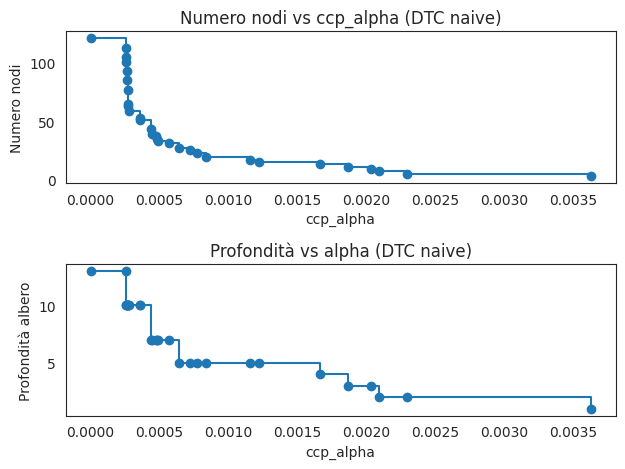

In [ ]:
# Plot grafici numero nodi vs ccp_alpha e profondità vs alpha

node_counts = [clf.tree_.node_count for clf in clfs[:-1]]
depth = [clf.tree_.max_depth for clf in clfs[:-1]]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas[:-1], node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("ccp_alpha")
ax[0].set_ylabel("Numero nodi")
ax[0].set_title("Numero nodi vs ccp_alpha (DTC naive)")
ax[1].plot(ccp_alphas[:-1], depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("ccp_alpha")
ax[1].set_ylabel("Profondità albero")
ax[1].set_title("Profondità vs alpha (DTC naive)")
fig.tight_layout()

#### Predizioni e matrice di confusione

In [ ]:
# Predizione sui dati di test

y_pred = dtc_model.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred))
dtc_naive_test_accuracy = accuracy_score(y_test, y_pred)

Test accuracy: 0.9836477987421384


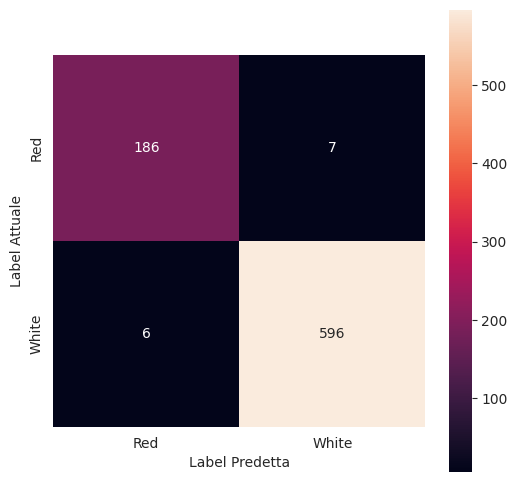

In [ ]:
# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

#### Performance evaluation

##### Misure per classe target e globali

In [ ]:
# Misure di performance a livello di CLASSE

print("Misure di performance Albero Decisionale a livello di classe\n")
dtc_naive_classification_report = classification_report(y_test, y_pred)
print(dtc_naive_classification_report)

Misure di performance Albero Decisionale a livello di classe

              precision    recall  f1-score   support

       False       0.97      0.96      0.97       193
        True       0.99      0.99      0.99       602

    accuracy                           0.98       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



In [ ]:
# Misure di performance GLOBALI

print("Misure di performance Albero Decisionale globali\n")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1-score:', f1_score(y_test, y_pred))

dtc_naive_global_report = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1-score': f1_score(y_test, y_pred)
}

Misure di performance Albero Decisionale globali

Accuracy: 0.9836477987421384
Precision: 0.988391376451078
Recall: 0.9900332225913622
F1-score: 0.9892116182572616


##### Curva ROC e misura AUC

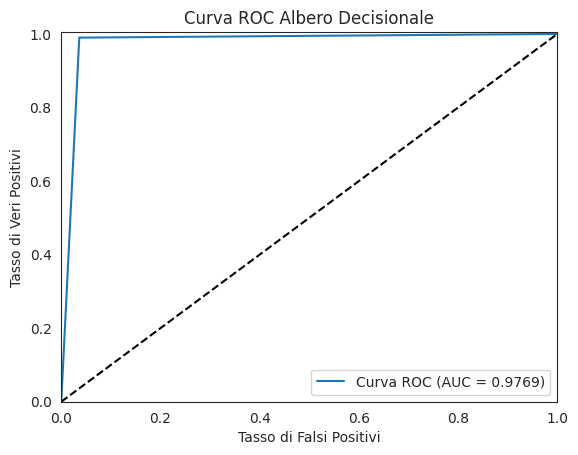

In [ ]:
# Calcola le probabilità di predizione del modello
y_pred_proba = dtc_model.predict_proba(X_test)
y_pred_prob = y_pred_proba[:, 1]

# Calcola la curva ROC
fpr_dtc_naive, tpr_dtc_naive, _ = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC della curva ROC
roc_auc_dtc_naive = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.plot(fpr_dtc_naive, tpr_dtc_naive, label='Curva ROC (AUC = %0.4f)' % roc_auc_dtc_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC Albero Decisionale')
plt.legend(loc="lower right")
plt.show()

##### Stratified 10-fold cross validation

In [ ]:
# Stratified 10-fold cross validation
print("Risultati Albero Decisionale stratified 10-fold cross validation\n\n")
cv_dict = my_cross_validation(DecisionTreeClassifier(random_state=42))

dtc_naive_cv_scores = cv_dict['scores']
dtc_naive_95_conf = cv_dict['95_conf']

Risultati Albero Decisionale stratified 10-fold cross validation


--- Accuracy di ogni fold, con media pari a 0.97846703 ---

[0.98301887 0.98679245 0.98113208 0.97358491 0.98490566 0.97542533
 0.97164461 0.98487713 0.97731569 0.96597353]

Intervallo di confidenza 95%: (0.9735992971003485, 0.9833347543316878)


--- Precision di ogni fold, con media pari a 0.97090731 ---

[0.9765415  0.98375547 0.97315883 0.96336143 0.98249284 0.96462063
 0.96375401 0.97792529 0.97016356 0.95329957]

Intervallo di confidenza 95%: (0.963981585593517, 0.9778330427114208)


--- Recall di ogni fold, con media pari a 0.97267267 ---

[0.97885607 0.98138772 0.9776799  0.96778889 0.97781054 0.9713292
 0.96148712 0.98254371 0.97016356 0.95768002]

Intervallo di confidenza 95%: (0.9666170080743726, 0.9787283389073309)


--- F1_score di ogni fold, con media pari a 0.97176681 ---

[0.97769141 0.98256407 0.9753905  0.9655467  0.98012189 0.96791022
 0.96261326 0.98020506 0.97016356 0.95546138]

Intervallo di confide

### Hyperparameter tuning

#### Grid search iperparametri ccp_alpha, splitter, criterion, max_depth, max_features massimizzando accuracy

In [ ]:
# Tuning degli iperparametri ccp_alpha, splitter, criterion, max_depth, max_features

tuned_parameters = {'ccp_alpha': [0.0005, 0.001, 0.0015, 0.0020, 0.0025, 0.003, 0.0035],
                    'splitter': ['best', 'random'],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'max_features': [None, 'sqrt', 'log2']}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), tuned_parameters, verbose=3, scoring='accuracy')
grid.fit(X_train_validation, y_train_validation)

Fitting 5 folds for each of 924 candidates, totalling 4620 fits
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=best;, score=0.989 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=best;, score=0.989 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=best;, score=0.987 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=best;, score=0.980 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=best;, score=0.976 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=random;, score=0.984 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=None, max_features=None, splitter=random;, score=0.981 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.0005, 0.001, 0.0015, 0.002, 0.0025,
                                       0.003, 0.0035],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=3)

In [ ]:
# Stampa degli iperparametri ottimali
print("Iperparametri ottimali:", grid.best_params_)

Iperparametri ottimali: {'ccp_alpha': 0.0005, 'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'splitter': 'best'}


### Modello ottimale

#### Training con tempo impiegato

In [ ]:
# Addestramento modello Albero Decisionale "ottimale" e calcolo tempo impiegato
start_time = time()
dtc_opt_model = DecisionTreeClassifier(**grid.best_params_, random_state=42)
estimator_dtc_optimal = dtc_opt_model.fit(X_train, y_train)
end_time = time()
dtc_opt_training_time = end_time - start_time
print("Tempo training Albero Decisionale ottimale in secondi:", round(dtc_opt_training_time, 4))

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(dtc_opt_model, filled=True, ax=ax)
plt.plot()

Tempo training Albero Decisionale ottimale in secondi: 0.0202


[]

In [ ]:
# Valutazione accuracy training

y_pred = dtc_opt_model.predict(X_train)
print('Training accuracy:', accuracy_score(y_train, y_pred))
dtc_opt_train_accuracy = accuracy_score(y_train, y_pred)

Training accuracy: 0.9919028340080972


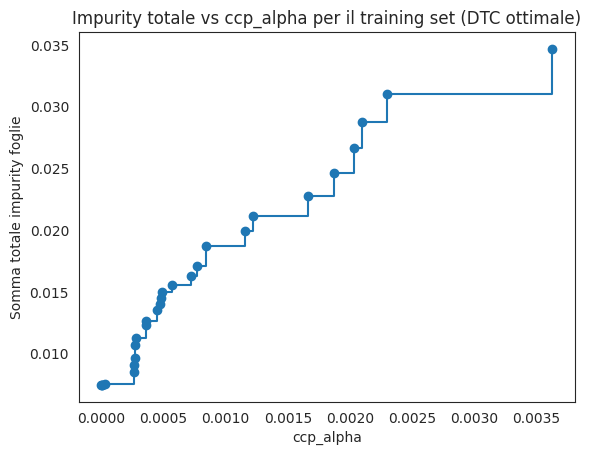

In [ ]:
# Plot grafico impurity vs ccp_alpha
# Qui viene escluso l'ultimo alpha poiché corrisponde al nodo radice

path_opt = dtc_opt_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_opt, impurities_opt = path_opt.ccp_alphas, path_opt.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas_opt[:-1], impurities_opt[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Somma totale impurity foglie")
ax.set_title("Impurity totale vs ccp_alpha per il training set (DTC ottimale)");

In [ ]:
# Valore ccp_alpha più alto, corrispondente all'albero con solo radice

# Occorre rimuovere dal dictionary degli iperparametri la chiave ccp_alpha poiché nel for serve poterlo settare
tmp_new_params = grid.best_params_.copy()
tmp_new_params.pop('ccp_alpha')

clfs_opt = []
for ccp_alpha in ccp_alphas_opt:
    clf = DecisionTreeClassifier(**tmp_new_params, random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs_opt.append(clf)

print("(DTC ottimale) Numero nodi albero: {} con ccp_alpha: {} e profondità: {}".format(
clfs_opt[-1].tree_.node_count, ccp_alphas_opt[-1], clfs_opt[-1].tree_.max_depth))

(DTC ottimale) Numero nodi albero: 1 con ccp_alpha: 0.3521089213075762 e profondità: 0


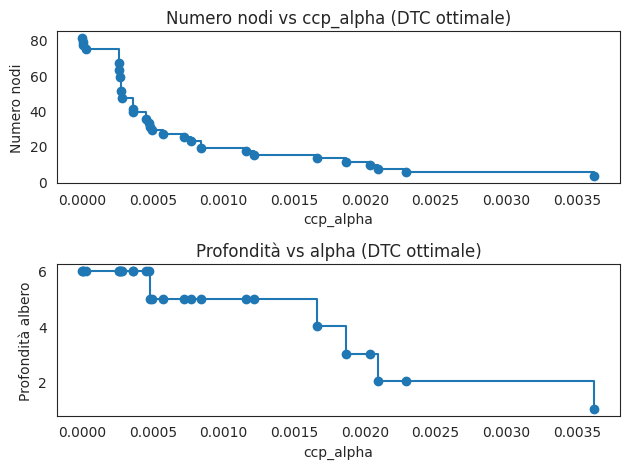

In [ ]:
# Plot grafici numero nodi vs ccp_alpha e profondità vs alpha

node_counts_opt = [clf.tree_.node_count for clf in clfs_opt[:-1]]
depth_opt = [clf.tree_.max_depth for clf in clfs_opt[:-1]]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas_opt[:-1], node_counts_opt, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("ccp_alpha")
ax[0].set_ylabel("Numero nodi")
ax[0].set_title("Numero nodi vs ccp_alpha (DTC ottimale)")
ax[1].plot(ccp_alphas_opt[:-1], depth_opt, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("ccp_alpha")
ax[1].set_ylabel("Profondità albero")
ax[1].set_title("Profondità vs alpha (DTC ottimale)")
fig.tight_layout()

#### Predizioni e matrice di confusione

In [ ]:
# Predizione sui dati di test

y_pred_opt = dtc_opt_model.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, y_pred_opt))
dtc_opt_test_accuracy = accuracy_score(y_test, y_pred_opt)

Test accuracy: 0.9861635220125786


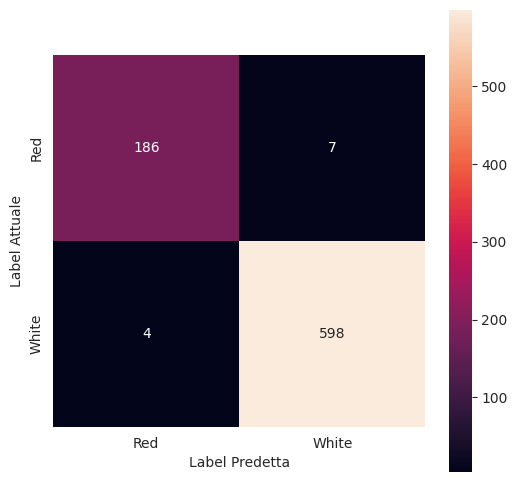

In [ ]:
# Creo la matrice di confusione
cm = confusion_matrix(y_test, y_pred_opt)

# Plotto la matrice di confusione
plt.figure(figsize=(6,6))
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                        xticklabels=['Red', 'White'],
                        yticklabels=['Red', 'White'])
# Imposto le label
plt.ylabel('Label Attuale')
plt.xlabel('Label Predetta');

#### Performance evaluation

##### Misure per classe target e globali

In [ ]:
# Misure di performance a livello di CLASSE

print("Misure di performance Albero Decisionale ottimale a livello di classe\n")
dtc_opt_classification_report = classification_report(y_test, y_pred_opt)
print(dtc_opt_classification_report)

Misure di performance Albero Decisionale ottimale a livello di classe

              precision    recall  f1-score   support

       False       0.98      0.96      0.97       193
        True       0.99      0.99      0.99       602

    accuracy                           0.99       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.99      0.99      0.99       795



In [ ]:
# Misure di performance GLOBALI

print("Misure di performance Albero Decisionale ottimale globali\n")
print('Accuracy:', accuracy_score(y_test, y_pred_opt))
print('Precision:', precision_score(y_test, y_pred_opt))
print('Recall:', recall_score(y_test, y_pred_opt))
print('F1-score:', f1_score(y_test, y_pred_opt))

dtc_opt_global_report = {
    'accuracy': accuracy_score(y_test, y_pred_opt),
    'precision': precision_score(y_test, y_pred_opt),
    'recall': recall_score(y_test, y_pred_opt),
    'f1-score': f1_score(y_test, y_pred_opt)
}

Misure di performance Albero Decisionale ottimale globali

Accuracy: 0.9861635220125786
Precision: 0.9884297520661157
Recall: 0.9933554817275747
F1-score: 0.9908864954432477


##### Curva ROC e misura AUC

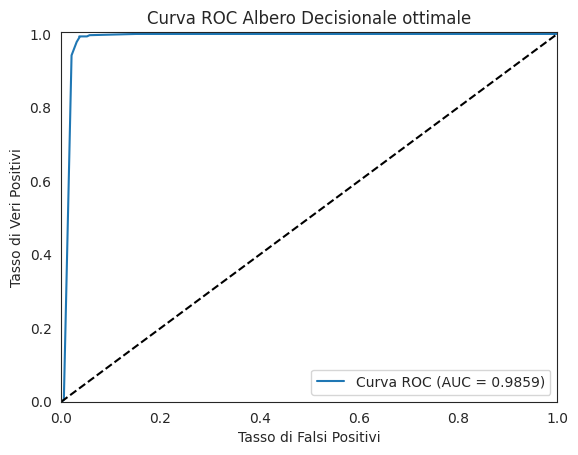

In [ ]:
# Calcola le probabilità di predizione del modello
y_pred_optimal_proba = dtc_opt_model.predict_proba(X_test)
y_pred_optimal_prob = y_pred_optimal_proba[:, 1]

# Calcola la curva ROC
fpr_dtc_opt, tpr_dtc_opt, _ = roc_curve(y_test, y_pred_optimal_prob)

# Calcola l'AUC della curva ROC
roc_auc_dtc_opt = roc_auc_score(y_test, y_pred_optimal_prob)

# Disegna la curva ROC
plt.plot(fpr_dtc_opt, tpr_dtc_opt, label='Curva ROC (AUC = %0.4f)' % roc_auc_dtc_opt)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curva ROC Albero Decisionale ottimale')
plt.legend(loc="lower right")
plt.show()

##### Learning curves modello "naive" e ottimale

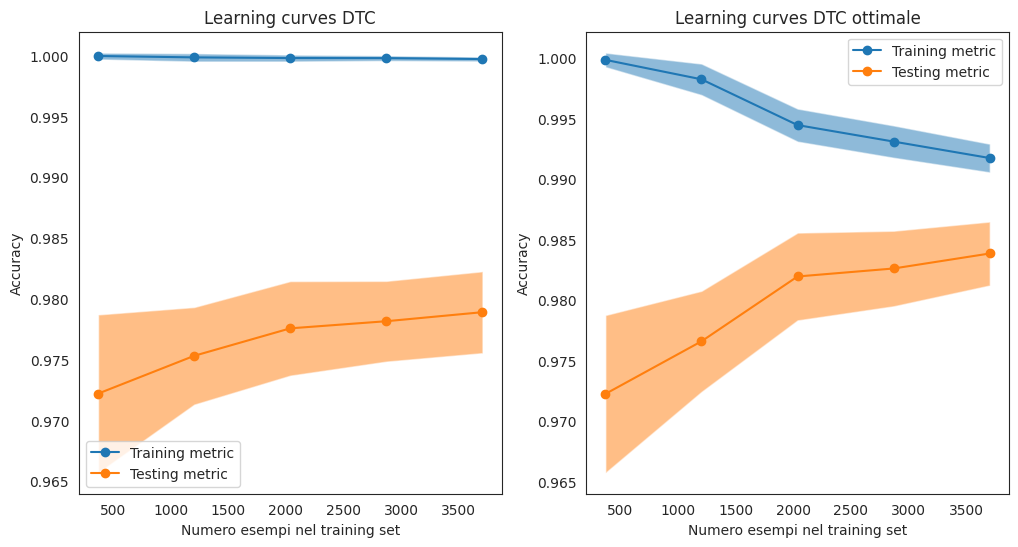

In [ ]:
# Confronto learning curves DTC e DTC ottimale

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

common_params = {
    "X": X,
    "y": y,
    "cv": ShuffleSplit(n_splits=100, test_size=0.3, random_state=42),
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "score_name": "Accuracy",
    "score_type": "both"
}

LearningCurveDisplay.from_estimator(estimator_dtc, **common_params, ax=axes[0])
LearningCurveDisplay.from_estimator(estimator_dtc_optimal, **common_params, ax=axes[1])

axes[0].set_xlabel("Numero esempi nel training set")
axes[1].set_xlabel("Numero esempi nel training set")

axes[0].set_title("Learning curves DTC")
axes[1].set_title("Learning curves DTC ottimale")

plt.show()

##### Stratified 10-fold cross validation

In [ ]:
# Stratified 10-fold cross validation
print("Risultati DTC ottimale stratified 10-fold cross validation\n\n")
cv_dict = my_cross_validation(DecisionTreeClassifier(**grid.best_params_, random_state=42))

dtc_opt_cv_scores = cv_dict['scores']
dtc_opt_95_conf = cv_dict['95_conf']

Risultati DTC ottimale stratified 10-fold cross validation


--- Accuracy di ogni fold, con media pari a 0.9830021 ---

[0.98867925 0.9754717  0.98679245 0.98679245 0.98113208 0.98109641
 0.98865784 0.97731569 0.98487713 0.97920605]

Intervallo di confidenza 95%: (0.9795709789810085, 0.9864332297431773)


--- Precision di ogni fold, con media pari a 0.97763312 ---

[0.98509142 0.96272894 0.98158467 0.99127182 0.97527247 0.97738665
 0.98285044 0.97016356 0.98240867 0.96757253]

Intervallo di confidenza 95%: (0.9713601478264929, 0.9839060861790193)


--- Recall di ogni fold, con media pari a 0.97791085 ---

[0.98509142 0.97379278 0.98389445 0.97426471 0.97527247 0.97270164
 0.98751645 0.97016356 0.97767437 0.9787366 ]

Intervallo di confidenza 95%: (0.9737482326832271, 0.9820734577626758)


--- F1_score di ogni fold, con media pari a 0.9776888 ---

[0.98509142 0.96808338 0.98273222 0.98238994 0.97527247 0.97501417
 0.98515379 0.97016356 0.98001134 0.97297573]

Intervallo di confidenza 95

# Analisi risultati

Si analizzano i risultati dei diversi modelli utilizzati durante gli esperimenti.

Vengono visualizzati riepiloghi dei dati ottenuti sia nei modelli "naive" sia in quelli ottimali.

## Analisi modelli "naive"

### Tempi di training

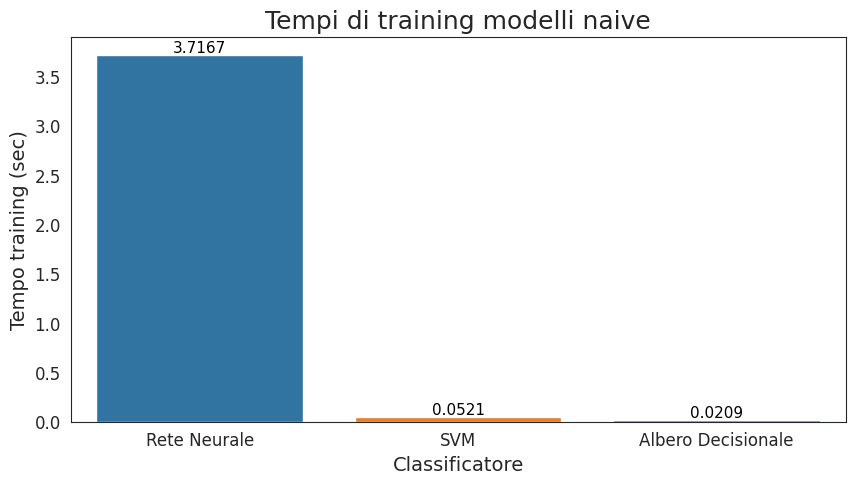

In [ ]:
# Confronto dei tempi di training in secondi

classifier_names = ['Rete Neurale', 'SVM', 'Albero Decisionale']

model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

naive_training_times = [nn_naive_training_time, svm_training_time, dtc_training_time]

plt.figure(figsize=(10, 5))
plt.title("Tempi di training modelli naive", size=18)
ax = sns.barplot(x=classifier_names, y=naive_training_times, hue=classifier_names, palette=model_colors)

for p in ax.patches:
    ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Classificatore', fontsize=14)
plt.ylabel('Tempo training (sec)', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Accuracy training e test

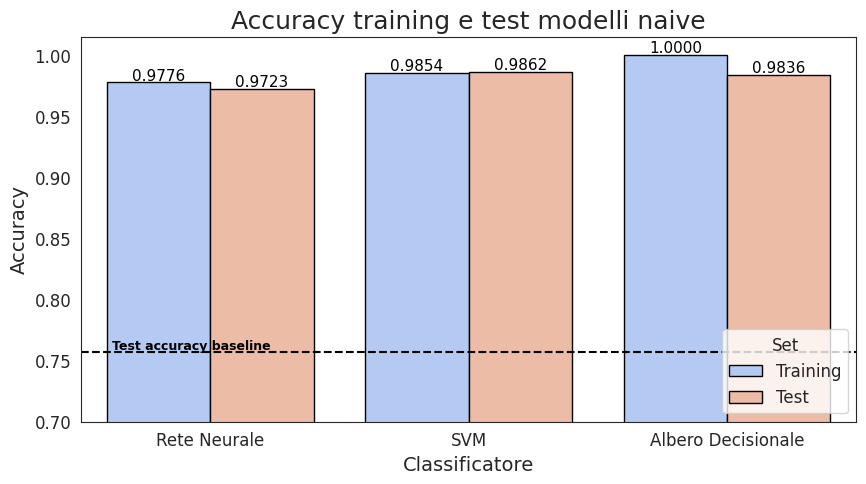

In [ ]:
# Confronto delle accuracy di training e test

plt.figure(figsize=(10, 5))
plt.title("Accuracy training e test modelli naive", size=18)

training_accuracies = [nn_naive_train_accuracy, svm_naive_train_accuracy, dtc_naive_train_accuracy]
testing_accuracies = [nn_naive_test_accuracy, svm_naive_test_accuracy, dtc_naive_test_accuracy]

accuracies = training_accuracies + testing_accuracies
labels = ['Training'] * len(training_accuracies) + ['Test'] * len(testing_accuracies)

data = {'Classificatore': classifier_names * 2, 'Accuracy': accuracies, 'Set': labels}
ax = sns.barplot(x='Classificatore', y='Accuracy', hue='Set', data=data, palette='coolwarm', edgecolor='black')

for p in ax.patches:
    if p.get_height() > 0:
      ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.axhline(y=baseline_test_accuracy, color='black', linestyle='--')
ax.annotate("Test accuracy baseline", xy=(-0.38, baseline_test_accuracy + 0.002),
                fontsize=9, color='black', fontweight='bold')

plt.xlabel('Classificatore', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.7, 1.015])

plt.legend(title='Set', fontsize=12, title_fontsize=12, loc='lower right');

### Accuracy, precision, recall, f1-score

In [ ]:
# Rete Neurale naive

print("Classification report - Rete Neurale naive\n\n")

print(nn_naive_classification_report)

Classification report - Rete Neurale naive


              precision    recall  f1-score   support

       False       0.92      0.97      0.94       193
        True       0.99      0.97      0.98       602

    accuracy                           0.97       795
   macro avg       0.95      0.97      0.96       795
weighted avg       0.97      0.97      0.97       795



In [ ]:
# SVM naive

print("Classification report - SVM naive\n\n")

print(svm_naive_classification_report)

Classification report - SVM naive


              precision    recall  f1-score   support

       False       0.97      0.97      0.97       193
        True       0.99      0.99      0.99       602

    accuracy                           0.99       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.99      0.99      0.99       795



In [ ]:
# Albero Decisionale naive

print("Classification report - Albero Decisionale naive\n\n")

print(dtc_naive_classification_report)

Classification report - Albero Decisionale naive


              precision    recall  f1-score   support

       False       0.97      0.96      0.97       193
        True       0.99      0.99      0.99       602

    accuracy                           0.98       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



In [ ]:
# Misure globali

data = [
    [nn_naive_global_report['accuracy'], svm_naive_global_report['accuracy'], dtc_naive_global_report['accuracy']],
    [nn_naive_global_report['precision'], svm_naive_global_report['precision'], dtc_naive_global_report['precision']],
    [nn_naive_global_report['recall'], svm_naive_global_report['recall'], dtc_naive_global_report['recall']],
    [nn_naive_global_report['f1-score'], svm_naive_global_report['f1-score'], dtc_naive_global_report['f1-score']]
]

print("Riepilogo misure globali modelli naive\n")

pd.DataFrame(data, columns=classifier_names, index=["Accuracy", "Precision", "Recall", "F1-score"])

Riepilogo misure globali modelli naive



Rete Neurale       SVM  Albero Decisionale
Accuracy       0.972327  0.986164            0.983648
Precision      0.991525  0.991681            0.988391
Recall         0.971761  0.990033            0.990033
F1-score       0.981544  0.990856            0.989212

### Curve ROC

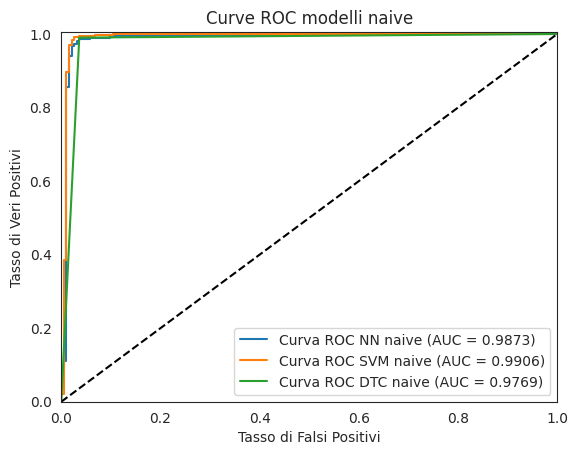

In [ ]:
# Curve ROC dei modelli naive

plt.plot(fpr_nn_naive, tpr_nn_naive, label='Curva ROC NN naive (AUC = %0.4f)' % roc_auc_nn_naive)
plt.plot(fpr_svm_naive, tpr_svm_naive, label='Curva ROC SVM naive (AUC = %0.4f)' % roc_auc_svm_naive)
plt.plot(fpr_dtc_naive, tpr_dtc_naive, label='Curva ROC DTC naive (AUC = %0.4f)' % roc_auc_dtc_naive)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curve ROC modelli naive')
plt.legend(loc="lower right")
plt.show()

### Stratified 10-fold cross validation

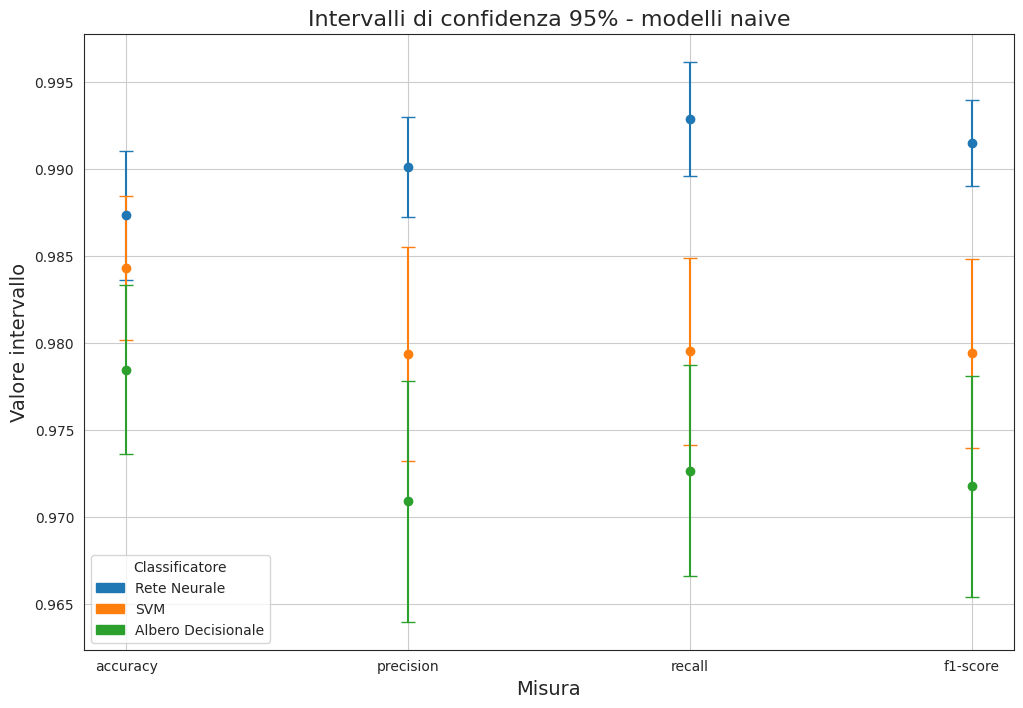

In [ ]:
# Plot intervalli di confidenza 95% modelli naive

legend_patches = [Patch(color=color, label=label) for color, label in zip(model_colors, classifier_names)]

tmp_dict = dict(zip(classifier_names, model_colors))

plt.figure(figsize=(12, 8))

for model_name, intervals in [('Rete Neurale', nn_naive_95_conf),
                              ('SVM', svm_naive_95_conf),
                              ('Albero Decisionale', dtc_naive_95_conf)]:
    model_color = tmp_dict[model_name]
    for key, value in intervals.items():
        plt.errorbar(x=[key], y=(value[0] + value[1]) / 2, yerr=(value[1] - value[0]) / 2,
                     fmt='o', capsize=5, color=model_color, label=f'{model_name} - {key}')

plt.title("Intervalli di confidenza 95% - modelli naive", fontsize=16)
plt.xlabel("Misura", fontsize=14)
plt.ylabel("Valore intervallo", fontsize=14)
plt.grid(True)
plt.legend(handles=legend_patches, title='Classificatore', loc='lower left')
plt.show()

In [ ]:
# Dataframe medie metriche Stratified 10-fold cross validation modelli naive

cv_data = [
    [np.mean(nn_naive_cv_scores['accuracy']), np.mean(svm_naive_cv_scores['accuracy']), np.mean(dtc_naive_cv_scores['accuracy'])],
    [np.mean(nn_naive_cv_scores['precision']), np.mean(svm_naive_cv_scores['precision']), np.mean(dtc_naive_cv_scores['precision'])],
    [np.mean(nn_naive_cv_scores['recall']), np.mean(svm_naive_cv_scores['recall']), np.mean(dtc_naive_cv_scores['recall'])],
    [np.mean(nn_naive_cv_scores['f1-score']), np.mean(svm_naive_cv_scores['f1-score']), np.mean(dtc_naive_cv_scores['f1-score'])]
]

print("Riepilogo medie metriche in Stratified 10-fold cross validation - modelli naive\n")

pd.DataFrame(cv_data, columns=classifier_names, index=["Accuracy", "Precision", "Recall", "F1-score"])

Riepilogo medie metriche in Stratified 10-fold cross validation - modelli naive



Rete Neurale       SVM  Albero Decisionale
Accuracy       0.987347  0.984326            0.978467
Precision      0.990144  0.979381            0.970907
Recall         0.992899  0.979524            0.972673
F1-score       0.991514  0.979413            0.971767

## Analisi modelli ottimali

### Tempi di training

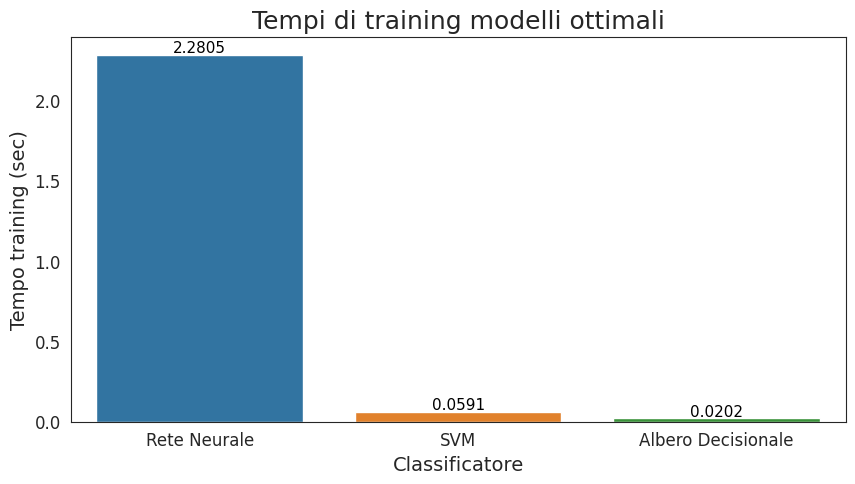

In [ ]:
# Confronto dei tempi di training in secondi

opt_training_times = [nn_hp_training_time, svm_optimal_training_time, dtc_opt_training_time]

plt.figure(figsize=(10, 5))
plt.title("Tempi di training modelli ottimali", size=18)
ax = sns.barplot(x=classifier_names, y=opt_training_times, hue=classifier_names, palette=model_colors)

for p in ax.patches:
    ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Classificatore', fontsize=14)
plt.ylabel('Tempo training (sec)', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Accuracy training e test

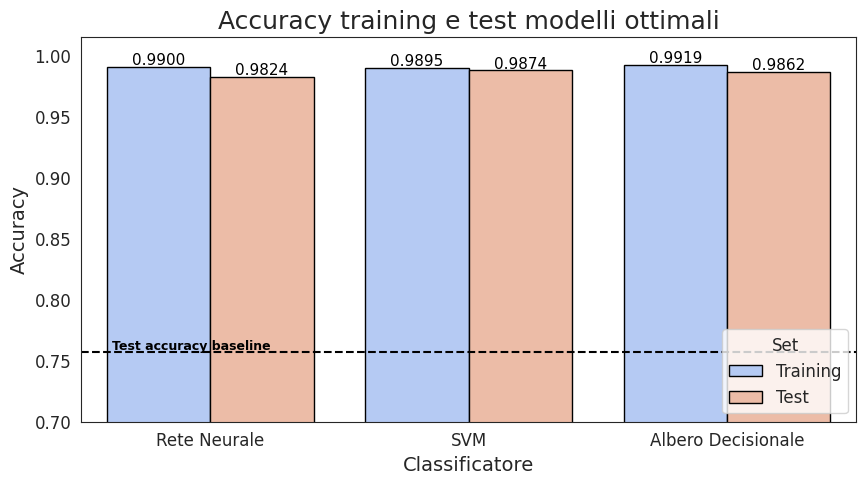

In [ ]:
# Confronto delle accuracy di training e test

plt.figure(figsize=(10, 5))
plt.title("Accuracy training e test modelli ottimali", size=18)

opt_training_accuracies = [nn_hp_train_accuracy, svm_opt_train_accuracy, dtc_opt_train_accuracy]
opt_testing_accuracies = [nn_hp_test_accuracy, svm_opt_test_accuracy, dtc_opt_test_accuracy]

opt_accuracies = opt_training_accuracies + opt_testing_accuracies
opt_labels = ['Training'] * len(opt_training_accuracies) + ['Test'] * len(opt_testing_accuracies)

opt_data = {'Classificatore': classifier_names * 2, 'Accuracy': opt_accuracies, 'Set': opt_labels}
ax = sns.barplot(x='Classificatore', y='Accuracy', hue='Set', data=opt_data, palette='coolwarm', edgecolor='black')

for p in ax.patches:
    if p.get_height() > 0:
      ax.annotate("%.4f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.axhline(y=baseline_test_accuracy, color='black', linestyle='--')
ax.annotate("Test accuracy baseline", xy=(-0.38, baseline_test_accuracy + 0.002),
                fontsize=9, color='black', fontweight='bold')

plt.xlabel('Classificatore', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0.7, 1.015])

plt.legend(title='Set', fontsize=12, title_fontsize=12, loc='lower right');

### Accuracy, precision, recall, f1-score

In [ ]:
# Rete Neurale ottimale

print("Classification report - Rete Neurale ottimale\n\n")

print(nn_hp_classification_report)

Classification report - Rete Neurale ottimale


              precision    recall  f1-score   support

       False       0.96      0.97      0.96       193
        True       0.99      0.99      0.99       602

    accuracy                           0.98       795
   macro avg       0.97      0.98      0.98       795
weighted avg       0.98      0.98      0.98       795



In [ ]:
# SVM ottimale

print("Classification report - SVM ottimale\n\n")

print(svm_opt_classification_report)

Classification report - SVM ottimale


              precision    recall  f1-score   support

       False       0.98      0.96      0.97       193
        True       0.99      1.00      0.99       602

    accuracy                           0.99       795
   macro avg       0.99      0.98      0.98       795
weighted avg       0.99      0.99      0.99       795



In [ ]:
# Albero Decisionale ottimale

print("Classification report - Albero Decisionale ottimale\n\n")

print(dtc_opt_classification_report)

Classification report - Albero Decisionale ottimale


              precision    recall  f1-score   support

       False       0.98      0.96      0.97       193
        True       0.99      0.99      0.99       602

    accuracy                           0.99       795
   macro avg       0.98      0.98      0.98       795
weighted avg       0.99      0.99      0.99       795



In [ ]:
# Misure globali

opt_data = [
    [nn_hp_global_report['accuracy'], svm_opt_global_report['accuracy'], dtc_opt_global_report['accuracy']],
    [nn_hp_global_report['precision'], svm_opt_global_report['precision'], dtc_opt_global_report['precision']],
    [nn_hp_global_report['recall'], svm_opt_global_report['recall'], dtc_opt_global_report['recall']],
    [nn_hp_global_report['f1-score'], svm_opt_global_report['f1-score'], dtc_opt_global_report['f1-score']]
]

print("Riepilogo misure globali modelli ottimali\n")

pd.DataFrame(opt_data, columns=classifier_names, index=["Accuracy", "Precision", "Recall", "F1-score"])

Riepilogo misure globali modelli ottimali



Rete Neurale       SVM  Albero Decisionale
Accuracy       0.982390  0.987421            0.986164
Precision      0.990000  0.988449            0.988430
Recall         0.986711  0.995017            0.993355
F1-score       0.988353  0.991722            0.990886

### Curve ROC

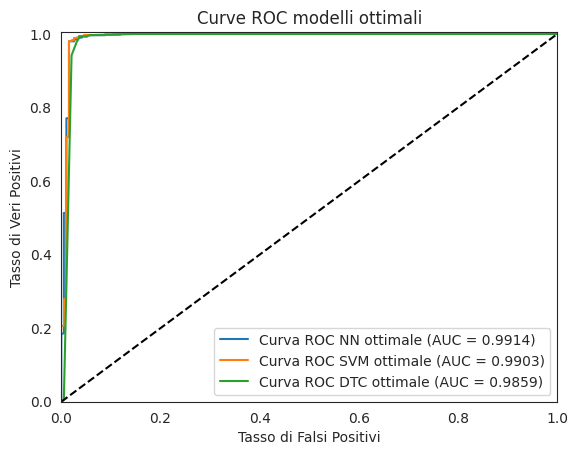

In [ ]:
# Curve ROC dei modelli ottimali

plt.plot(fpr_nn_hp, tpr_nn_hp, label='Curva ROC NN ottimale (AUC = %0.4f)' % roc_auc_nn_hp)
plt.plot(fpr_svm_opt, tpr_svm_opt, label='Curva ROC SVM ottimale (AUC = %0.4f)' % roc_auc_svm_opt)
plt.plot(fpr_dtc_opt, tpr_dtc_opt, label='Curva ROC DTC ottimale (AUC = %0.4f)' % roc_auc_dtc_opt)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('Tasso di Falsi Positivi')
plt.ylabel('Tasso di Veri Positivi')
plt.title('Curve ROC modelli ottimali')
plt.legend(loc="lower right")
plt.show()

### Stratified 10-fold cross validation

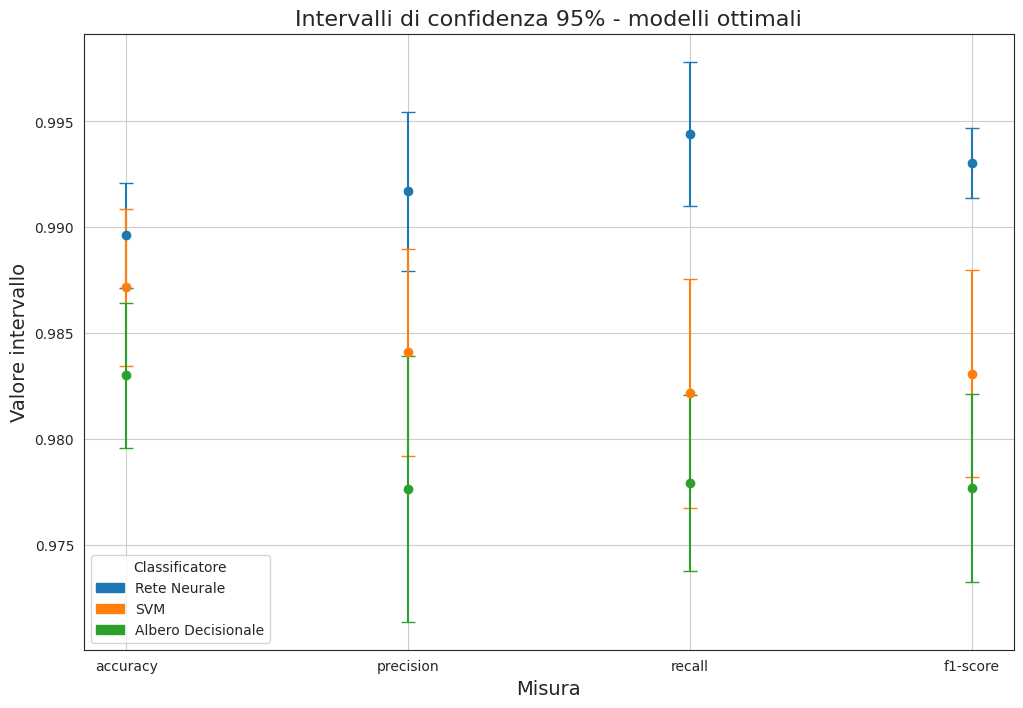

In [ ]:
# Plot intervalli di confidenza 95% modelli ottimali

plt.figure(figsize=(12, 8))

for model_name, intervals in [('Rete Neurale', nn_hp_95_conf),
                              ('SVM', svm_opt_95_conf),
                              ('Albero Decisionale', dtc_opt_95_conf)]:
    model_color = tmp_dict[model_name]
    for key, value in intervals.items():
        plt.errorbar(x=[key], y=(value[0] + value[1]) / 2, yerr=(value[1] - value[0]) / 2,
                     fmt='o', capsize=5, color=model_color, label=f'{model_name} - {key}')

plt.title("Intervalli di confidenza 95% - modelli ottimali", fontsize=16)
plt.xlabel("Misura", fontsize=14)
plt.ylabel("Valore intervallo", fontsize=14)
plt.grid(True)
plt.legend(handles=legend_patches, title='Classificatore', loc='lower left')
plt.show()

In [ ]:
# Dataframe medie metriche Stratified 10-fold cross validation modelli ottimali

cv_opt_data = [
    [np.mean(nn_hp_cv_scores['accuracy']), np.mean(svm_opt_cv_scores['accuracy']), np.mean(dtc_opt_cv_scores['accuracy'])],
    [np.mean(nn_hp_cv_scores['precision']), np.mean(svm_opt_cv_scores['precision']), np.mean(dtc_opt_cv_scores['precision'])],
    [np.mean(nn_hp_cv_scores['recall']), np.mean(svm_opt_cv_scores['recall']), np.mean(dtc_opt_cv_scores['recall'])],
    [np.mean(nn_hp_cv_scores['f1-score']), np.mean(svm_opt_cv_scores['f1-score']), np.mean(dtc_opt_cv_scores['f1-score'])]
]

print("Riepilogo medie metriche in Stratified 10-fold cross validation - modelli ottimali\n")

pd.DataFrame(cv_opt_data, columns=classifier_names, index=["Accuracy", "Precision", "Recall", "F1-score"])

Riepilogo medie metriche in Stratified 10-fold cross validation - modelli ottimali



Rete Neurale       SVM  Albero Decisionale
Accuracy       0.989613  0.987158            0.983002
Precision      0.991692  0.984083            0.977633
Recall         0.994418  0.982153            0.977911
F1-score       0.993035  0.983087            0.977689